# Импорты

In [1071]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unittest
import time
import math
import mlflow
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression, mutual_info_classif, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from typing import Literal, Optional
from tqdm import tqdm
from scipy.stats import chi2_contingency

try:
    import phik
except:
    !pip install phik
    import phik
try:
    import shap
except:
    !pip install shap
    import shap


# Метрики к лабораторной работе

In [1072]:
def custom_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def custom_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def custom_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def custom_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [1073]:
mse_scorer = make_scorer(custom_mse, greater_is_better=False)
mae_scorer = make_scorer(custom_mae, greater_is_better=False)
r2_scorer = make_scorer(custom_r2, greater_is_better=True)
mape_scorer = make_scorer(custom_mape, greater_is_better=False)

In [1074]:
def train_my_metrics(score_dict, data, exp_id):
    with mlflow.start_run(experiment_id=exp_id):
        for i, (y_true, y_pred) in enumerate(data, 1):
            with mlflow.start_run(nested=True, run_name=f"dataset_{i}"):
                mlflow.log_params({
                    "dataset_size": len(y_true),
                    "y_true_mean": np.mean(y_true),
                    "y_pred_mean": np.mean(y_pred)
                })
                
                for metric_name, (custom_func, sklearn_func) in score_dict.items():
                    try:
                        custom_val = custom_func(y_true, y_pred)
                        sklearn_val = sklearn_func(y_true, y_pred)
                        
                        mlflow.log_metrics({
                            f"custom_{metric_name}": custom_val,
                            f"sklearn_{metric_name}": sklearn_val,
                            f"delta_{metric_name}": abs(custom_val - sklearn_val)
                        })
                        
                        print(f"Dataset {i} | {metric_name.upper()}:")
                        print(f"  Custom: {custom_val:.6f}")
                        print(f"  Sklearn: {sklearn_val:.6f}")
                        print(f"  Difference: {abs(custom_val - sklearn_val):.6f}")
                        
                    except Exception as e:
                        print(f"Error calculating {metric_name} for dataset {i}: {str(e)}")
                        mlflow.log_text(f"Error in {metric_name}: {str(e)}", f"errors/{metric_name}.txt")


In [1075]:
score_dict = {
    "mse" : (custom_mse, mean_squared_error),
    "mae" : (custom_mae, mean_absolute_error),
    "r2" : (custom_r2, r2_score),
    "mape" : (custom_mape, mean_absolute_percentage_error)
}

In [1076]:
data = [
    (np.array([3, -0.5, 2, 7]), np.array([2.5, 0.0, 2, 8])),  
    (np.array([1, 2, 3, 4]), np.array([1.1, 1.9, 3.1, 3.9])),  
    (np.array([10, 20, 30]), np.array([15, 15, 15])),         
    (np.array([0.1, 0.2, 0.3]), np.array([0.15, 0.25, 0.35]))  
]

In [1077]:
mlflow.set_experiment("Train my metrics")

<Experiment: artifact_location='s3://mlops-check/mlflow/837016175570321269', creation_time=1746624865343, experiment_id='837016175570321269', last_update_time=1746624865343, lifecycle_stage='active', name='Train my metrics', tags={}>

In [1078]:
train_my_metrics(score_dict, data, '837016175570321269')

2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run dataset_1 at: http://mlflow-service:5000/#/experiments/837016175570321269/runs/89a3a545ebbf4ac39bbd5fb5f279aaa2.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/837016175570321269.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run dataset_2 at: http://mlflow-service:5000/#/experiments/837016175570321269/runs/0650c6cc98b8497c96dce6beb1598dd6.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/837016175570321269.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run dataset_3 at: http://mlflow-service:5000/#/experiments/837016175570321269/runs/83a2bd27f5a6475a8ce43b1154311922.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experimen

Dataset 1 | MSE:
  Custom: 0.375000
  Sklearn: 0.375000
  Difference: 0.000000
Dataset 1 | MAE:
  Custom: 0.500000
  Sklearn: 0.500000
  Difference: 0.000000
Dataset 1 | R2:
  Custom: 0.948608
  Sklearn: 0.948608
  Difference: 0.000000
Dataset 1 | MAPE:
  Custom: 0.327381
  Sklearn: 0.327381
  Difference: 0.000000
Dataset 2 | MSE:
  Custom: 0.010000
  Sklearn: 0.010000
  Difference: 0.000000
Dataset 2 | MAE:
  Custom: 0.100000
  Sklearn: 0.100000
  Difference: 0.000000
Dataset 2 | R2:
  Custom: 0.992000
  Sklearn: 0.992000
  Difference: 0.000000
Dataset 2 | MAPE:
  Custom: 0.052083
  Sklearn: 0.052083
  Difference: 0.000000
Dataset 3 | MSE:
  Custom: 91.666667
  Sklearn: 91.666667
  Difference: 0.000000
Dataset 3 | MAE:
  Custom: 8.333333
  Sklearn: 8.333333
  Difference: 0.000000
Dataset 3 | R2:
  Custom: -0.375000
  Sklearn: -0.375000
  Difference: 0.000000
Dataset 3 | MAPE:
  Custom: 0.416667
  Sklearn: 0.416667
  Difference: 0.000000
Dataset 4 | MSE:
  Custom: 0.002500
  Sklearn: 0

# Scalers для лабораторной работы

In [1079]:
class MyZScaler:
    def __init__(self, with_mean=True, with_std=True, epsilon=1e-8):
        self.with_mean = with_mean
        self.with_std = with_std
        self.epsilon = epsilon  
        self.mean_ = None
        self.scale_ = None
        
    def fit(self, X, y=None):
        if not isinstance(X, np.ndarray):
            raise TypeError("Input must be numpy array")
            
        if len(X.shape) != 2:
            raise ValueError("Input must be 2D array")
            
        if self.with_mean:
            self.mean_ = np.mean(X, axis=0)
        else:
            self.mean_ = np.zeros(X.shape[1])
            
        if self.with_std:
            self.scale_ = np.std(X, axis=0)
        else:
            self.scale_ = np.ones(X.shape[1])
        
        self.scale_ = np.maximum(self.scale_, self.epsilon)
        
        return self
    
    def transform(self, X):
        if self.mean_ is None or self.scale_ is None:
            raise RuntimeError("Scaler must be fitted first")
            
        if X.shape[1] != self.mean_.shape[0]:
            raise ValueError("Number of features must match")
            
        return (X - self.mean_) / self.scale_  
    
    def inverse_transform(self, X):
        if self.mean_ is None or self.scale_ is None:
            raise RuntimeError("Scaler must be fitted first")
            
        if X.shape[1] != self.mean_.shape[0]:
            raise ValueError("Number of features must match")
            
        return X * self.scale_ + self.mean_

class MyMinMaxScaler:
    def __init__(self, feature_range=(0, 1), epsilon=1e-8):
        self.feature_range = feature_range
        self.epsilon = epsilon 
        self.data_min_ = None
        self.data_max_ = None
        self.scale_ = None
        self.min_ = None
        
    def fit(self, X, y=None):
        if not isinstance(X, np.ndarray):
            raise TypeError("Input must be numpy array")
            
        if len(X.shape) != 2:
            raise ValueError("Input must be 2D array")
            
        self.data_min_ = np.min(X, axis=0)
        self.data_max_ = np.max(X, axis=0)
        
        feature_min, feature_max = self.feature_range
        range_diff = self.data_max_ - self.data_min_
        
        self.scale_ = (feature_max - feature_min) / np.maximum(range_diff, self.epsilon)
        self.min_ = feature_min - self.data_min_ * self.scale_
        
        return self
    
    def transform(self, X):
        if self.scale_ is None or self.min_ is None:
            raise RuntimeError("Scaler must be fitted first")
            
        if X.shape[1] != self.scale_.shape[0]:
            raise ValueError("Number of features must match")
            
        return X * self.scale_ + self.min_
    def inverse_transform(self, X):
        if self.scale_ is None or self.min_ is None:
            raise RuntimeError("Scaler must be fitted first")
            
        if X.shape[1] != self.scale_.shape[0]:
            raise ValueError("Number of features must match")
            
        return (X - self.min_) / np.maximum(self.scale_, self.epsilon)

In [1080]:
mlflow.set_experiment("Train my scalers")

<Experiment: artifact_location='s3://mlops-check/mlflow/626439206706620191', creation_time=1746624892532, experiment_id='626439206706620191', last_update_time=1746624892532, lifecycle_stage='active', name='Train my scalers', tags={}>

In [1081]:
datasets = {
    "simple": np.array([[1, 2], [3, 4], [5, 6]], dtype=np.float64),
    "with_zeros": np.array([[0, 0], [1, 1], [2, 2]], dtype=np.float64),
    "negative": np.array([[-1, -2], [0, 0], [1, 2]], dtype=np.float64),
    "large_range": np.array([[1, 100], [2, 200], [3, 300]], dtype=np.float64),
    "constant_feature": np.array([[1, 5], [2, 5], [3, 5]], dtype=np.float64)
}

In [1082]:
def compare_scalers(dataset_name, X):
    with mlflow.start_run(run_name=f"dataset_{dataset_name}", nested=True):
        dataset_info = {
            "dataset": [dataset_name],
            "shape": [str(X.shape)],
            "mean": [np.mean(X, axis=0).tolist()],
            "std": [np.std(X, axis=0).tolist()]
        }
        
        print("\n" + "="*50)
        print(f"Dataset: {dataset_name}")
        print("Shape:", X.shape)
        print("Mean values:", np.mean(X, axis=0))
        print("Std values:", np.std(X, axis=0))
        
        my_zscaler = MyZScaler()
        sklearn_zscaler = StandardScaler()
        
        my_zscaler.fit(X)
        sklearn_zscaler.fit(X)
        
        my_zscaled = my_zscaler.transform(X)
        sklearn_zscaled = sklearn_zscaler.transform(X)
        
        zscaler_metrics = {
            "zscaler_mean_diff": np.mean(np.abs(my_zscaler.mean_ - sklearn_zscaler.mean_)),
            "zscaler_scale_diff": np.mean(np.abs(my_zscaler.scale_ - sklearn_zscaler.scale_)),
            "zscaler_result_diff": np.mean(np.abs(my_zscaled - sklearn_zscaled))
        }
        
        mlflow.log_metrics(zscaler_metrics)
        print("\nZScaler comparison:")
        display(pd.DataFrame([zscaler_metrics]))
        
        my_minmax = MyMinMaxScaler(feature_range=(0, 1))
        sklearn_minmax = MinMaxScaler(feature_range=(0, 1))
        
        my_minmax.fit(X)
        sklearn_minmax.fit(X)
        
        my_minmax_scaled = my_minmax.transform(X)
        sklearn_minmax_scaled = sklearn_minmax.transform(X)
        print(my_minmax.scale_, sklearn_minmax.scale_)
        minmax_metrics = {
            "minmax_scale_diff": np.mean(np.abs(my_minmax.scale_ - sklearn_minmax.scale_)),
            "minmax_min_diff": np.mean(np.abs(my_minmax.min_ - sklearn_minmax.min_)),
            "minmax_result_diff": np.mean(np.abs(my_minmax_scaled - sklearn_minmax_scaled))
        }
        
        mlflow.log_metrics(minmax_metrics)
        print("\nMinMaxScaler comparison:")
        display(pd.DataFrame([minmax_metrics]))
        
        return {
            "dataset_info": dataset_info,
            "zscaler_comparison": zscaler_metrics,
            "minmax_comparison": minmax_metrics
        }


In [1083]:
with mlflow.start_run(run_name="Scaler_comparison", experiment_id='626439206706620191'):
    for name, data in datasets.items():
        compare_scalers(name, data)
    


Dataset: simple
Shape: (3, 2)
Mean values: [3. 4.]
Std values: [1.63299316 1.63299316]

ZScaler comparison:


,zscaler_mean_diff,zscaler_scale_diff,zscaler_result_diff
0,0.0,0.0,0.0


[0.25 0.25] [0.25 0.25]

MinMaxScaler comparison:


,minmax_scale_diff,minmax_min_diff,minmax_result_diff
0,0.0,0.0,0.0


2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run dataset_simple at: http://mlflow-service:5000/#/experiments/626439206706620191/runs/02c29685e9c2488baad280437827762b.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/626439206706620191.



Dataset: with_zeros
Shape: (3, 2)
Mean values: [1. 1.]
Std values: [0.81649658 0.81649658]

ZScaler comparison:


,zscaler_mean_diff,zscaler_scale_diff,zscaler_result_diff
0,0.0,0.0,0.0


[0.5 0.5] [0.5 0.5]

MinMaxScaler comparison:


,minmax_scale_diff,minmax_min_diff,minmax_result_diff
0,0.0,0.0,0.0


2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run dataset_with_zeros at: http://mlflow-service:5000/#/experiments/626439206706620191/runs/e19f30d8b0354e90af32403ed3565a0e.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/626439206706620191.



Dataset: negative
Shape: (3, 2)
Mean values: [0. 0.]
Std values: [0.81649658 1.63299316]

ZScaler comparison:


,zscaler_mean_diff,zscaler_scale_diff,zscaler_result_diff
0,0.0,0.0,0.0


[0.5  0.25] [0.5  0.25]

MinMaxScaler comparison:


,minmax_scale_diff,minmax_min_diff,minmax_result_diff
0,0.0,0.0,0.0


2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run dataset_negative at: http://mlflow-service:5000/#/experiments/626439206706620191/runs/699dfef56eed4210bab15715c83d370b.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/626439206706620191.



Dataset: large_range
Shape: (3, 2)
Mean values: [  2. 200.]
Std values: [ 0.81649658 81.64965809]

ZScaler comparison:


,zscaler_mean_diff,zscaler_scale_diff,zscaler_result_diff
0,0.0,0.0,0.0


[0.5   0.005] [0.5   0.005]

MinMaxScaler comparison:


,minmax_scale_diff,minmax_min_diff,minmax_result_diff
0,0.0,0.0,0.0


2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run dataset_large_range at: http://mlflow-service:5000/#/experiments/626439206706620191/runs/74134db33ed2402eb1c39c39628aea2c.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/626439206706620191.



Dataset: constant_feature
Shape: (3, 2)
Mean values: [2. 5.]
Std values: [0.81649658 0.        ]

ZScaler comparison:


,zscaler_mean_diff,zscaler_scale_diff,zscaler_result_diff
0,0.0,0.5,0.0


[5.e-01 1.e+08] [0.5 1. ]

MinMaxScaler comparison:


,minmax_scale_diff,minmax_min_diff,minmax_result_diff
0,49999999.5,249999997.5,0.0


2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run dataset_constant_feature at: http://mlflow-service:5000/#/experiments/626439206706620191/runs/e14c4581cd7e4793a64979e71033a418.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/626439206706620191.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run Scaler_comparison at: http://mlflow-service:5000/#/experiments/626439206706620191/runs/5c6e5e4135b84669868b17a9a60efdfc.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/626439206706620191.


# CV для лабораторной работы

In [1084]:
RANDOM_STATE = 42

In [1085]:
class MyKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
        
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        
        if self.n_splits > n_samples:
            raise ValueError(
                f"Cannot have number of splits n_splits={self.n_splits} greater"
                f" than the number of samples: n_samples={n_samples}."
            )
            
        indices = np.arange(n_samples)
        if self.shuffle:
            rng = np.random.RandomState(self.random_state)
            rng.shuffle(indices)

        for i in range(self.n_splits):
            test_mask = np.zeros(n_samples, dtype=bool)
            test_size = n_samples // self.n_splits
            if i < n_samples % self.n_splits:
                test_size += 1
            start = (n_samples * i) // self.n_splits
            stop = start + test_size
            test_mask[indices[start:stop]] = True
            yield indices[~test_mask], indices[test_mask]

class MyLeaveOneOut:
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        indices = np.arange(n_samples)
        for i in range(n_samples):
            test_idx = [i]
            train_idx = np.delete(indices, i)
            yield train_idx, test_idx

In [1086]:
mlflow.set_experiment("Test CV`s")

<Experiment: artifact_location='s3://mlops-check/mlflow/798505883412654513', creation_time=1746624911486, experiment_id='798505883412654513', last_update_time=1746624911486, lifecycle_stage='active', name='Test CV`s', tags={}>

In [1087]:
def log_split_comparison(my_train, my_test, sk_train, sk_test, split_num, cv_type):
    """Логирует сравнение одного сплита в MLflow"""
    train_match = np.array_equal(my_train, sk_train)
    test_match = np.array_equal(my_test, sk_test)
    
    mlflow.log_metrics({
        f"{cv_type}_split_{split_num}_train_match": int(train_match),
        f"{cv_type}_split_{split_num}_test_match": int(test_match)
    })

In [1088]:
def compare_splitters():
    X = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    
    with mlflow.start_run(experiment_id = '798505883412654513'):
        mlflow.log_param("dataset_size", len(X))
        mlflow.log_param("dataset_values", str(X.tolist()))
        
        kfold_params = {"n_splits": 5}
        mlflow.log_params({"kfold_" + k: v for k, v in kfold_params.items()})
        
        my_kfold = MyKFold(**kfold_params)
        sk_kfold = KFold(**kfold_params)
        
        print("KFold сравнение:")
        for i, ((my_train, my_test), (sk_train, sk_test)) in enumerate(zip(my_kfold.split(X), sk_kfold.split(X))):
            print(f"Split {i}:")
            print(f"Train: {my_train} == {sk_train}", np.array_equal(my_train, sk_train))
            print(f"Test:  {my_test} == {sk_test}", np.array_equal(my_test, sk_test))
            print("-" * 40)
            
            log_split_comparison(my_train, my_test, sk_train, sk_test, i, "kfold")
        
        print("\nLeaveOneOut сравнение:")
        my_loo = MyLeaveOneOut()
        sk_loo = LeaveOneOut()
        
        for i, ((my_train, my_test), (sk_train, sk_test)) in enumerate(zip(my_loo.split(X), sk_loo.split(X))):
            print(f"Sample {i}:")
            print(f"Train: {my_train} == {sk_train}", np.array_equal(my_train, sk_train))
            print(f"Test:  {my_test} == {sk_test}", np.array_equal(my_test, sk_test))
            print("-" * 40)
            
            log_split_comparison(my_train, my_test, sk_train, sk_test, i, "loo")
        
        mlflow.log_metric("kfold_total_splits", kfold_params["n_splits"])
        mlflow.log_metric("loo_total_splits", len(X))


In [1089]:
compare_splitters()

KFold сравнение:
Split 0:
Train: [2 3 4 5 6 7 8 9] == [2 3 4 5 6 7 8 9] True
Test:  [0 1] == [0 1] True
----------------------------------------
Split 1:
Train: [0 1 4 5 6 7 8 9] == [0 1 4 5 6 7 8 9] True
Test:  [2 3] == [2 3] True
----------------------------------------
Split 2:
Train: [0 1 2 3 6 7 8 9] == [0 1 2 3 6 7 8 9] True
Test:  [4 5] == [4 5] True
----------------------------------------
Split 3:
Train: [0 1 2 3 4 5 8 9] == [0 1 2 3 4 5 8 9] True
Test:  [6 7] == [6 7] True
----------------------------------------
Split 4:
Train: [0 1 2 3 4 5 6 7] == [0 1 2 3 4 5 6 7] True
Test:  [8 9] == [8 9] True
----------------------------------------

LeaveOneOut сравнение:
Sample 0:
Train: [1 2 3 4 5 6 7 8 9] == [1 2 3 4 5 6 7 8 9] True
Test:  [0] == [0] True
----------------------------------------
Sample 1:
Train: [0 2 3 4 5 6 7 8 9] == [0 2 3 4 5 6 7 8 9] True
Test:  [1] == [1] True
----------------------------------------
Sample 2:
Train: [0 1 3 4 5 6 7 8 9] == [0 1 3 4 5 6 7 8 9] T

2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run valuable-grub-420 at: http://mlflow-service:5000/#/experiments/798505883412654513/runs/3a760bbea4fc40aea4a0343f295606ba.
2025/05/07 15:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/798505883412654513.


# Линейная регрессия для лабораторной работы

In [1090]:
class MyLinearRegression:
    def __init__(self, method='analytic', regularization=None, alpha=0.1, p=2, 
                 l1_ratio=0.5, learning_rate=0.01, max_iter=1000, tol=1e-4, batch_size=32):
        self.method = method          
        self.regularization = regularization  
        self.alpha = alpha            
        self.p = p                    
        self.l1_ratio = l1_ratio     
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.batch_size = batch_size
        self.weights = None
        self.loss_history = []

    def get_params(self, deep=True):
            return {
                'method': self.method,
                'learning_rate': self.learning_rate,
                'max_iter': self.max_iter,
                'regularization': self.regularization,
                'alpha': self.alpha,
                'l1_ratio': self.l1_ratio,
                'p': self.p
            }
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
        
    def _add_intercept(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])
    
    def _compute_gradient(self, X, y, weights):
        m = X.shape[0]
        error = X.dot(weights) - y
        grad = X.T.dot(error) / m
        
        if self.regularization == 'l2':
            grad[1:] += self.alpha * weights[1:]
        elif self.regularization == 'l1':
            grad[1:] += self.alpha * np.sign(weights[1:])
        elif self.regularization == 'elasticnet':
            grad[1:] += self.alpha * (self.l1_ratio * np.sign(weights[1:]) + 
                          (1 - self.l1_ratio) * weights[1:])
        elif self.regularization == 'lp':
            epsilon = 1e-8
            grad[1:] += self.alpha * self.p * np.sign(weights[1:]) * (np.abs(weights[1:]) + epsilon)**(self.p - 1)

        
        return grad
    
    def fit(self, X, y):
        X = self._add_intercept(X)
        m, n = X.shape
        
        self.weights = np.zeros(n)
        
        if self.method == 'analytic':
            XTX = X.T.dot(X)
            
            if self.regularization == 'l2':
                XTX += self.alpha * np.eye(n)
                XTX[0,0] = 0  
            elif self.regularization == 'l1':
                raise NotImplementedError("L1 regularization not supported for analytic method")
            
            self.weights = np.linalg.pinv(XTX).dot(X.T.dot(y))
            
        elif self.method in ['gd', 'sgd']:
            for i in range(self.max_iter):
                if self.method == 'sgd':
                    idx = np.random.choice(m, self.batch_size, replace=False)
                    X_batch = X[idx]
                    y_batch = y[idx]
                else:
                    X_batch = X
                    y_batch = y
                
                grad = self._compute_gradient(X_batch, y_batch, self.weights)
                self.weights -= self.learning_rate * grad
                
                loss = np.mean((X_batch.dot(self.weights) - y_batch)**2)
                self.loss_history.append(loss)
                
                if i > 0 and abs(self.loss_history[-1] - self.loss_history[-2]) < self.tol:
                    break
                    
        return self
    
    def predict(self, X):
        X = self._add_intercept(X)
        return X.dot(self.weights)

In [1091]:
from sklearn.datasets import make_regression

In [1092]:
mlflow.set_experiment("Linear reg test")

<Experiment: artifact_location='s3://mlops-check/mlflow/658874046489605455', creation_time=1746624928192, experiment_id='658874046489605455', last_update_time=1746624928192, lifecycle_stage='active', name='Linear reg test', tags={}>

In [1093]:
import time

In [1094]:
def compare_models():
    X, y = make_regression(n_samples=1000, n_features=10, noise=20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models = [
        ('My Analytic', MyLinearRegression(method='analytic'), {'method': 'analytic'}),
        ('My GD', MyLinearRegression(method='gd', learning_rate=0.01, max_iter=1000),
         {'method': 'gd', 'learning_rate': 0.01, 'max_iter': 1000}),
        ('My SGD', MyLinearRegression(method='sgd', learning_rate=0.01, max_iter=1000),
         {'method': 'sgd', 'learning_rate': 0.01, 'max_iter': 1000}),
        ('Sklearn Linear', LinearRegression(), {}),
        ('My Ridge', MyLinearRegression(method='analytic', regularization='l2', alpha=0.1),
         {'method': 'analytic', 'regularization': 'l2', 'alpha': 0.1}),
        ('Sklearn Ridge', Ridge(alpha=0.1), {'alpha': 0.1}),
        ('My Lasso', MyLinearRegression(method='gd', regularization='l1', alpha=0.1, max_iter=2000),
         {'method': 'gd', 'regularization': 'l1', 'alpha': 0.1, 'max_iter': 2000}),
        ('Sklearn Lasso', Lasso(alpha=0.1), {'alpha': 0.1}),
        ('My ElasticNet', MyLinearRegression(method='gd', regularization='elasticnet', alpha=0.1, l1_ratio=0.5),
         {'method': 'gd', 'regularization': 'elasticnet', 'alpha': 0.1, 'l1_ratio': 0.5}),
        ('Sklearn ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5), {'alpha': 0.1, 'l1_ratio': 0.5}),
        ('My Lp(p=1.5)', MyLinearRegression(method='gd', regularization='lp', alpha=0.1, p=1.5),
         {'method': 'gd', 'regularization': 'lp', 'alpha': 0.1, 'p': 1.5}),
        ('My Lp(p=3)', MyLinearRegression(method='gd', regularization='lp', alpha=0.1, p=3),
         {'method': 'gd', 'regularization': 'lp', 'alpha': 0.1, 'p': 3})
    ]

    results = []

    for name, model, params in models:
        with mlflow.start_run(run_name=name, experiment_id='658874046489605455'):
            start_time = time.time()
            model.fit(X_train, y_train)
            end_time = time.time()

            training_time = end_time - start_time
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)

            results.append({
                'Model': name,
                'MSE': mse,
                'R2': r2,
                'MAE': mae,
                'MAPE': mape,
                'Training Time': training_time
            })

            mlflow.log_params(params)
            mlflow.log_metric("MSE", mse)
            mlflow.log_metric("R2", r2)
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("MAPE", mape)
            mlflow.log_metric("Training Time", training_time)

            if hasattr(model, 'loss_history'):
                plt.figure()
                plt.plot(model.loss_history)
                plt.title(f'{name} Learning Curve')
                plt.xlabel('Iteration')
                plt.ylabel('MSE')
                plt.tight_layout()
                plot_path = f"data/{name.replace(' ', '_')}_loss_curve.png"
                plt.savefig(plot_path)
                mlflow.log_artifact(plot_path)
                plt.close()

    df = pd.DataFrame(results)
    print(df.round(4))

In [1095]:
compare_models()

2025/05/07 15:39:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run My Analytic at: http://mlflow-service:5000/#/experiments/658874046489605455/runs/15c4d6186f8c4ee8b1e2de586b9318b3.
2025/05/07 15:39:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/658874046489605455.
2025/05/07 15:39:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run My GD at: http://mlflow-service:5000/#/experiments/658874046489605455/runs/ee8823a4cb8d4a8a9f67407dceb728f9.
2025/05/07 15:39:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/658874046489605455.
2025/05/07 15:39:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run My SGD at: http://mlflow-service:5000/#/experiments/658874046489605455/runs/65f5f09c44384ca78fa61bd0305d64ce.
2025/05/07 15:39:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/65

                 Model         MSE      R2      MAE    MAPE  Training Time
0          My Analytic    380.4766  0.9774  15.5467  0.4075         0.0004
1                My GD    380.2333  0.9774  15.5377  0.4076         0.0082
2               My SGD    382.4535  0.9773  15.5909  0.4085         0.0311
3       Sklearn Linear    380.4766  0.9774  15.5467  0.4075         0.0007
4             My Ridge    378.9052  0.9775  15.5503  0.4137         0.0003
5        Sklearn Ridge    380.4476  0.9774  15.5455  0.4075         0.0009
6             My Lasso    381.0982  0.9774  15.5495  0.4065         0.0112
7        Sklearn Lasso    381.1750  0.9774  15.5520  0.4065         0.0007
8        My ElasticNet    412.8900  0.9755  16.2795  0.3989         0.0142
9   Sklearn ElasticNet    412.8306  0.9755  16.2782  0.3989         0.0007
10        My Lp(p=1.5)    386.1626  0.9771  15.6117  0.4012         0.0127
11          My Lp(p=3)  10943.2784  0.3500  84.2488  0.8221         0.0051


# Предобработка и загрузка данных

In [1096]:
train_df = pd.read_csv("data/train.csv", parse_dates = ["ApplicationDate"])
test_df = pd.read_csv("data/test.csv", parse_dates = ["ApplicationDate"], index_col = ['ID'])
ex_df = pd.read_csv("data/ex.csv", index_col = ['ID'])

In [1097]:
display(train_df.head(), train_df.shape)

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


(11017, 36)

In [1098]:
display(test_df.head(), test_df.shape)

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
ID,,,,,,,,,,,,,,,,,,,,,
0,1979-01-03,49,207095,850,14458,60,Single,0,Rent,376,...,6,Employed,High School,23,10626,0.104458,0.125350,325.532336,0.040650,1
1,2006-04-10,28,64653,674,65491,48,Single,2,Own,238,...,3,Employed,High School,3,299024,0.233491,0.260561,2210.247757,0.454410,0
2,2013-11-28,41,300000,768,16811,60,Single,1,Own,469,...,3,Employed,High School,19,6979,0.147811,0.154571,403.977431,0.034919,1
3,1995-08-24,50,300000,850,48737,36,Divorced,0,Mortgage,567,...,3,Self-Employed,Bachelor,26,8438,0.118737,0.099712,1571.946906,0.085558,1
4,1980-06-15,35,300000,672,51916,60,Single,6,Mortgage,106,...,7,Employed,Associate,12,436216,0.230916,0.237727,1486.675235,0.063707,1


(5000, 35)

In [1099]:
display(ex_df.head(), ex_df.shape)

,RiskScore
ID,
0,100.200243
1,7.853891
2,17.343710
3,101.840874
4,30.889202


(5000, 1)

In [1100]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ApplicationDate             10487 non-null  datetime64[ns]
 1   Age                         10487 non-null  float64       
 2   AnnualIncome                10487 non-null  float64       
 3   CreditScore                 9986 non-null   float64       
 4   LoanAmount                  9986 non-null   float64       
 5   LoanDuration                10487 non-null  float64       
 6   MaritalStatus               10487 non-null  object        
 7   NumberOfDependents          10487 non-null  float64       
 8   HomeOwnershipStatus         10487 non-null  object        
 9   MonthlyDebtPayments         9986 non-null   float64       
 10  CreditCardUtilizationRate   10487 non-null  float64       
 11  NumberOfOpenCreditLines     10487 non-null  float64   

Данные представляют из себя тренировочную, тестовую и таргет-тест выборку, содержащие как тестовые, временные так и категориальные переменные

## Исследовательский анализ данных

Выполним проверку на пропуски и дубликаты

In [1101]:
train_df.isna().sum()

ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel                 530
Experience          

In [1102]:
train_df = train_df.drop_duplicates()
train_df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


In [1103]:
test_df = test_df.drop_duplicates()
test_df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
ID,,,,,,,,,,,,,,,,,,,,,
0,1979-01-03,49,207095,850,14458,60,Single,0,Rent,376,...,6,Employed,High School,23,10626,0.104458,0.125350,325.532336,0.040650,1
1,2006-04-10,28,64653,674,65491,48,Single,2,Own,238,...,3,Employed,High School,3,299024,0.233491,0.260561,2210.247757,0.454410,0
2,2013-11-28,41,300000,768,16811,60,Single,1,Own,469,...,3,Employed,High School,19,6979,0.147811,0.154571,403.977431,0.034919,1
3,1995-08-24,50,300000,850,48737,36,Divorced,0,Mortgage,567,...,3,Self-Employed,Bachelor,26,8438,0.118737,0.099712,1571.946906,0.085558,1
4,1980-06-15,35,300000,672,51916,60,Single,6,Mortgage,106,...,7,Employed,Associate,12,436216,0.230916,0.237727,1486.675235,0.063707,1


In [1104]:
train_df.isna().sum()

ApplicationDate                 1
Age                             1
AnnualIncome                    1
CreditScore                   472
LoanAmount                    472
LoanDuration                    1
MaritalStatus                   1
NumberOfDependents              1
HomeOwnershipStatus             1
MonthlyDebtPayments           472
CreditCardUtilizationRate       1
NumberOfOpenCreditLines         1
NumberOfCreditInquiries         1
DebtToIncomeRatio               1
BankruptcyHistory             472
LoanPurpose                   472
PreviousLoanDefaults            1
PaymentHistory                  1
LengthOfCreditHistory           1
SavingsAccountBalance           1
CheckingAccountBalance        472
TotalAssets                   472
TotalLiabilities                1
MonthlyIncome                   1
UtilityBillsPaymentHistory      1
JobTenure                       1
EmploymentStatus                1
EducationLevel                  1
Experience                      1
NetWorth      

In [1105]:
train_df.isna().sum() / train_df.shape[0]

ApplicationDate               0.000100
Age                           0.000100
AnnualIncome                  0.000100
CreditScore                   0.047195
LoanAmount                    0.047195
LoanDuration                  0.000100
MaritalStatus                 0.000100
NumberOfDependents            0.000100
HomeOwnershipStatus           0.000100
MonthlyDebtPayments           0.047195
CreditCardUtilizationRate     0.000100
NumberOfOpenCreditLines       0.000100
NumberOfCreditInquiries       0.000100
DebtToIncomeRatio             0.000100
BankruptcyHistory             0.047195
LoanPurpose                   0.047195
PreviousLoanDefaults          0.000100
PaymentHistory                0.000100
LengthOfCreditHistory         0.000100
SavingsAccountBalance         0.000100
CheckingAccountBalance        0.047195
TotalAssets                   0.047195
TotalLiabilities              0.000100
MonthlyIncome                 0.000100
UtilityBillsPaymentHistory    0.000100
JobTenure                

In [1106]:
train_df['RiskScore'].isna().sum()

1

Отбросим все строки с пропусками в признаках, составляющий < 5% от общей размерности фрейма

In [1107]:
def get_missing_ratio(df):
    missing_ratio = df.isna().mean()
    
    result = pd.DataFrame({'missing_ratio': missing_ratio})
    
    return result

In [1108]:
cols_to_del = get_missing_ratio(train_df)
cols_to_del.sort_values(by = 'missing_ratio', ascending = False)

,missing_ratio
NetWorth,0.047195
BaseInterestRate,0.047195
LoanPurpose,0.047195
BankruptcyHistory,0.047195
TotalAssets,0.047195
MonthlyDebtPayments,0.047195
CheckingAccountBalance,0.047195
LoanAmount,0.047195
CreditScore,0.047195
InterestRate,0.000100


In [1109]:
cols_to_dropna = [col for col in train_df.columns if cols_to_del.loc[col, 'missing_ratio'] < 0.003]
cols_to_dropna

['ApplicationDate',
 'Age',
 'AnnualIncome',
 'LoanDuration',
 'MaritalStatus',
 'NumberOfDependents',
 'HomeOwnershipStatus',
 'CreditCardUtilizationRate',
 'NumberOfOpenCreditLines',
 'NumberOfCreditInquiries',
 'DebtToIncomeRatio',
 'PreviousLoanDefaults',
 'PaymentHistory',
 'LengthOfCreditHistory',
 'SavingsAccountBalance',
 'TotalLiabilities',
 'MonthlyIncome',
 'UtilityBillsPaymentHistory',
 'JobTenure',
 'EmploymentStatus',
 'EducationLevel',
 'Experience',
 'InterestRate',
 'MonthlyLoanPayment',
 'TotalDebtToIncomeRatio',
 'LoanApproved',
 'RiskScore']

In [1110]:
train_df = train_df.dropna(subset = cols_to_dropna).reset_index(drop = True)
cols_to_dropna.pop()
test_df = test_df.dropna(subset = cols_to_dropna).reset_index(drop = True)
train_df.isna().sum()

ApplicationDate                 0
Age                             0
AnnualIncome                    0
CreditScore                   471
LoanAmount                    471
LoanDuration                    0
MaritalStatus                   0
NumberOfDependents              0
HomeOwnershipStatus             0
MonthlyDebtPayments           471
CreditCardUtilizationRate       0
NumberOfOpenCreditLines         0
NumberOfCreditInquiries         0
DebtToIncomeRatio               0
BankruptcyHistory             471
LoanPurpose                   471
PreviousLoanDefaults            0
PaymentHistory                  0
LengthOfCreditHistory           0
SavingsAccountBalance           0
CheckingAccountBalance        471
TotalAssets                   471
TotalLiabilities                0
MonthlyIncome                   0
UtilityBillsPaymentHistory      0
JobTenure                       0
EmploymentStatus                0
EducationLevel                  0
Experience                      0
NetWorth      

In [1111]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ApplicationDate             10000 non-null  datetime64[ns]
 1   Age                         10000 non-null  float64       
 2   AnnualIncome                10000 non-null  float64       
 3   CreditScore                 9529 non-null   float64       
 4   LoanAmount                  9529 non-null   float64       
 5   LoanDuration                10000 non-null  float64       
 6   MaritalStatus               10000 non-null  object        
 7   NumberOfDependents          10000 non-null  float64       
 8   HomeOwnershipStatus         10000 non-null  object        
 9   MonthlyDebtPayments         9529 non-null   float64       
 10  CreditCardUtilizationRate   10000 non-null  float64       
 11  NumberOfOpenCreditLines     10000 non-null  float64    

Заметим, что только столбец `LoanPurpose` имеет признаки в категориальной переменной, остальные признаки с пропусками юмеют тип `float64`

Заполним численные признаки медианным значением

In [1112]:
numeric_cols = list(train_df.select_dtypes(include = ['float64']).columns)

for column in numeric_cols:
    train_df[column] = train_df[column].fillna(train_df[column].median())

numeric_cols.pop()
for column in numeric_cols:
    test_df[column] = test_df[column].fillna(test_df[column].median())
    
train_df.isna().sum()

ApplicationDate                 0
Age                             0
AnnualIncome                    0
CreditScore                     0
LoanAmount                      0
LoanDuration                    0
MaritalStatus                   0
NumberOfDependents              0
HomeOwnershipStatus             0
MonthlyDebtPayments             0
CreditCardUtilizationRate       0
NumberOfOpenCreditLines         0
NumberOfCreditInquiries         0
DebtToIncomeRatio               0
BankruptcyHistory               0
LoanPurpose                   471
PreviousLoanDefaults            0
PaymentHistory                  0
LengthOfCreditHistory           0
SavingsAccountBalance           0
CheckingAccountBalance          0
TotalAssets                     0
TotalLiabilities                0
MonthlyIncome                   0
UtilityBillsPaymentHistory      0
JobTenure                       0
EmploymentStatus                0
EducationLevel                  0
Experience                      0
NetWorth      

In [1113]:
train_df['LoanPurpose'].unique()

array(['Education', 'Home', 'Debt Consolidation', 'Auto', 'Other', nan],
      dtype=object)

Заполним пропуски неизвестным параметром наиболее популярным значением

In [1114]:
train_df['LoanPurpose'] = train_df['LoanPurpose'].fillna(train_df['LoanPurpose'].mode()[0])
test_df['LoanPurpose'] = test_df['LoanPurpose'].fillna(test_df['LoanPurpose'].mode()[0])
train_df.isna().sum()

ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
EmploymentStatus              0
EducationLevel                0
Experience                    0
NetWorth                      0
BaseInterestRate              0
Interest

## Распределения признаков

In [1115]:
num_cols= train_df.select_dtypes(include=['number']).columns
cat_cols = train_df.select_dtypes(include=['object']).columns


Analysis for column: Age


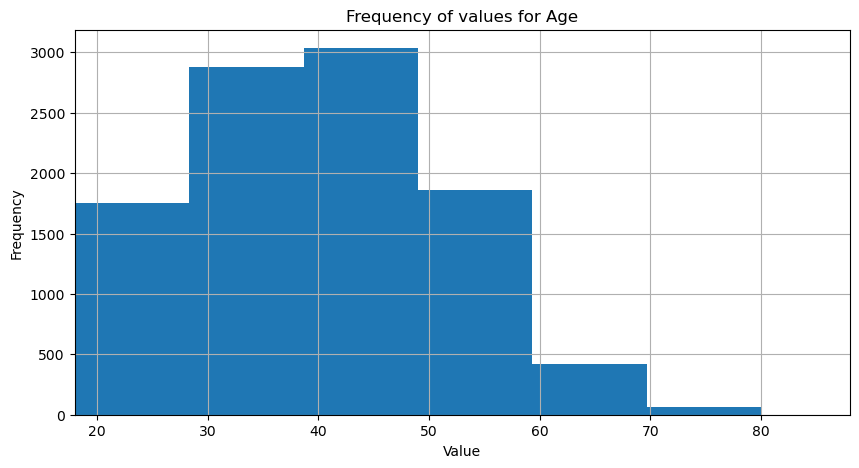

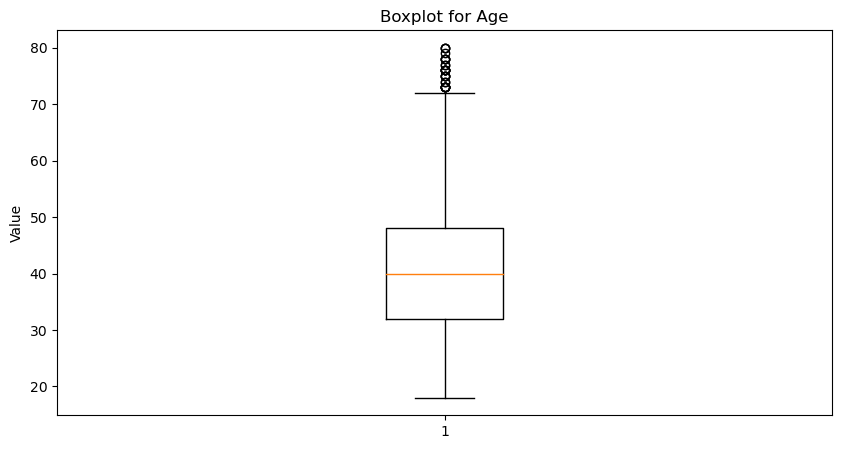

Descriptive statistics:


count    10000.000000
mean        39.839800
std         11.596611
min         18.000000
25%         32.000000
50%         40.000000
75%         48.000000
max         80.000000
Name: Age, dtype: float64


Analysis for column: AnnualIncome


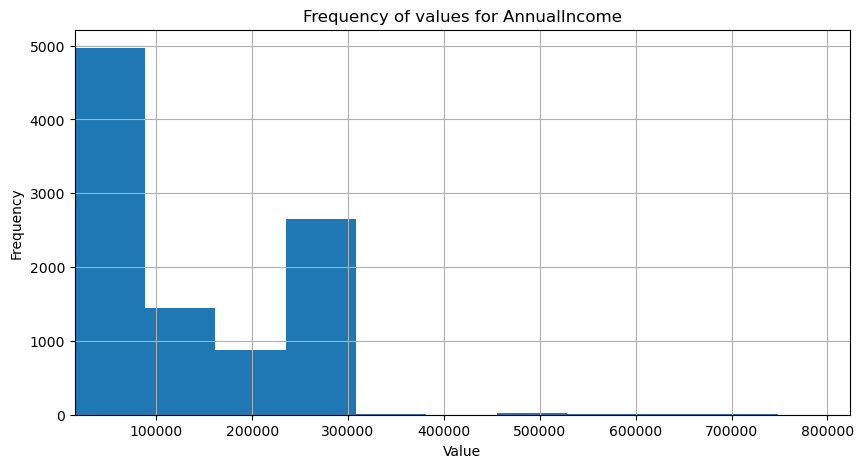

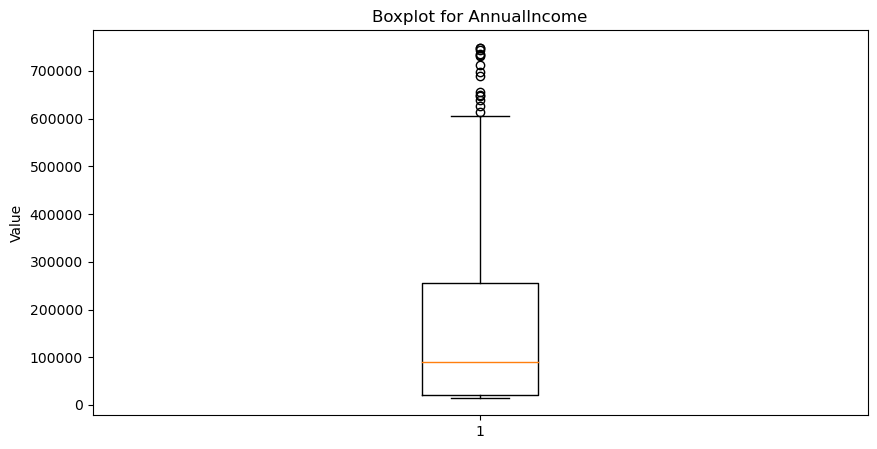

Descriptive statistics:


count     10000.000000
mean     131657.904200
std      115748.029821
min       15000.000000
25%       21308.250000
50%       89657.500000
75%      256315.500000
max      748508.000000
Name: AnnualIncome, dtype: float64


Analysis for column: CreditScore


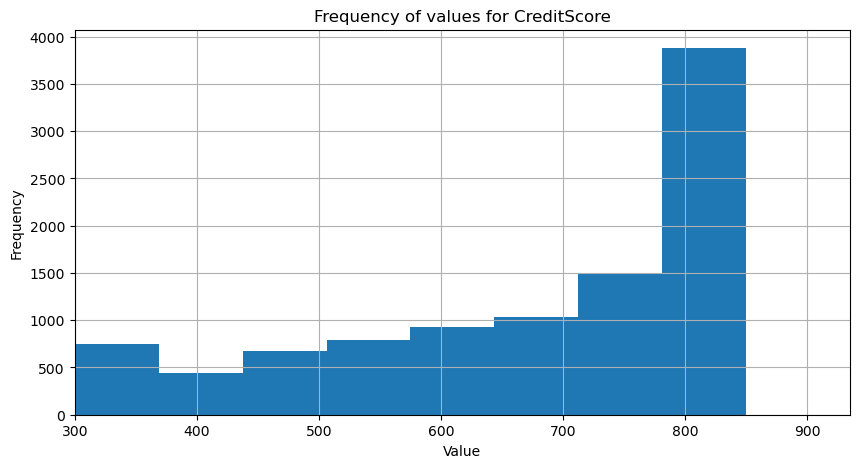

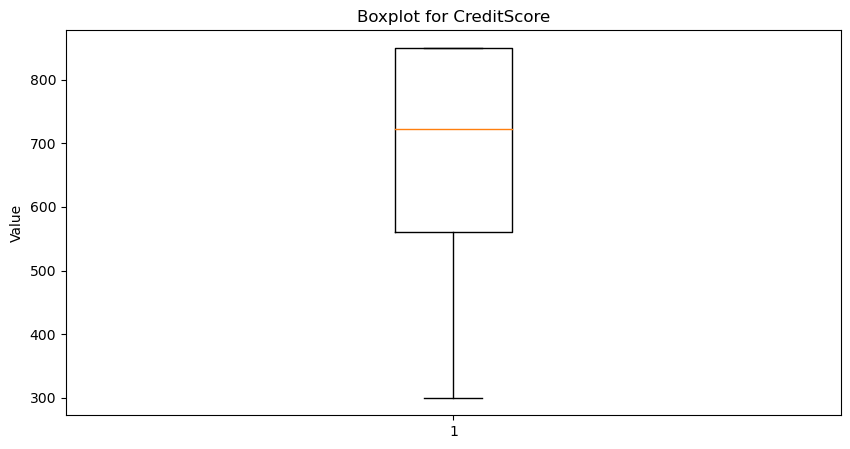

Descriptive statistics:


count    10000.000000
mean       680.332300
std        171.127127
min        300.000000
25%        561.000000
50%        723.000000
75%        850.000000
max        850.000000
Name: CreditScore, dtype: float64


Analysis for column: LoanAmount


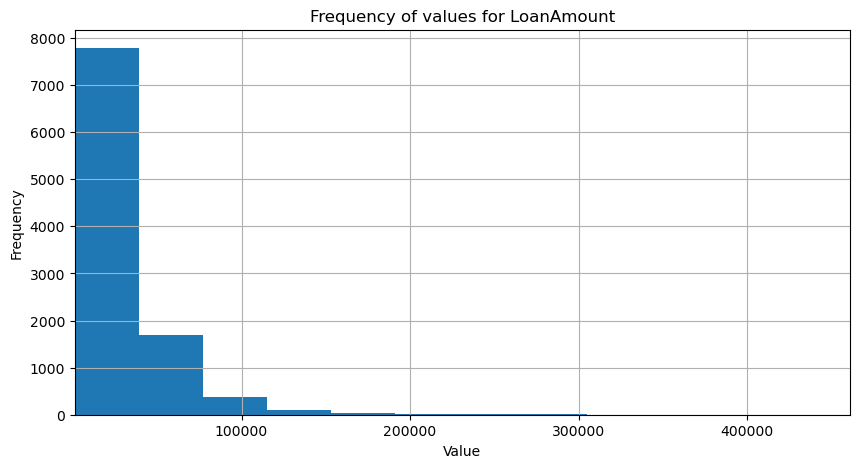

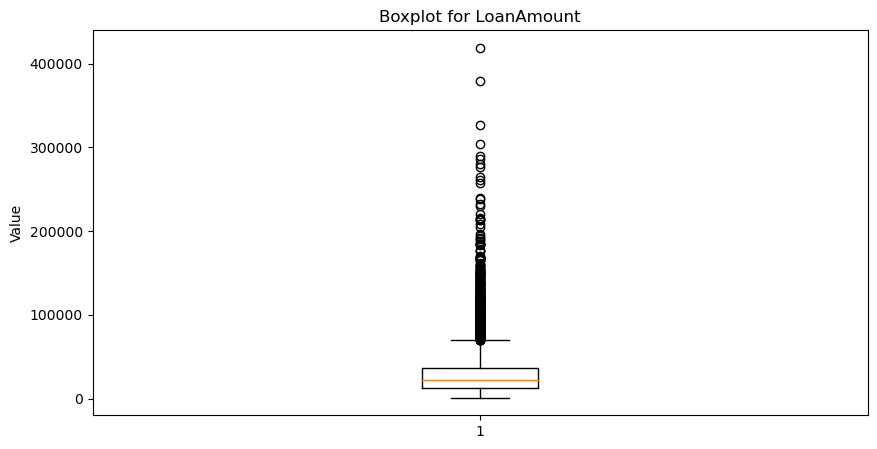

Descriptive statistics:


count     10000.000000
mean      29382.668800
std       26617.614694
min        1063.000000
25%       13094.000000
50%       21803.000000
75%       36039.000000
max      418997.000000
Name: LoanAmount, dtype: float64


Analysis for column: LoanDuration


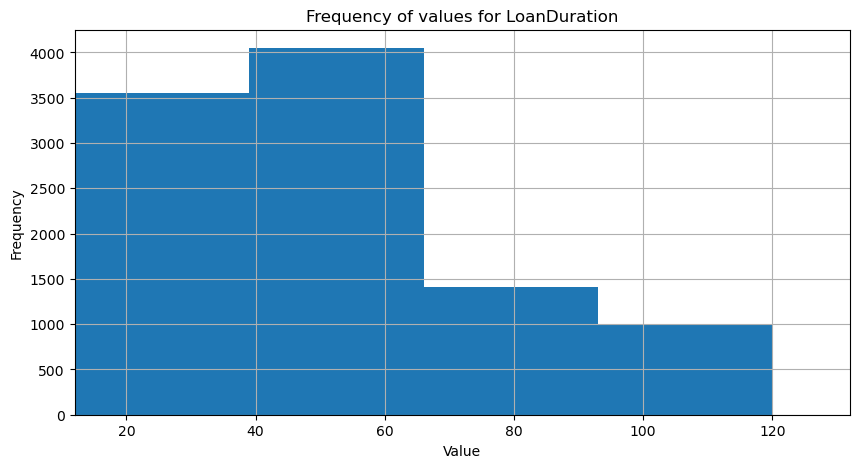

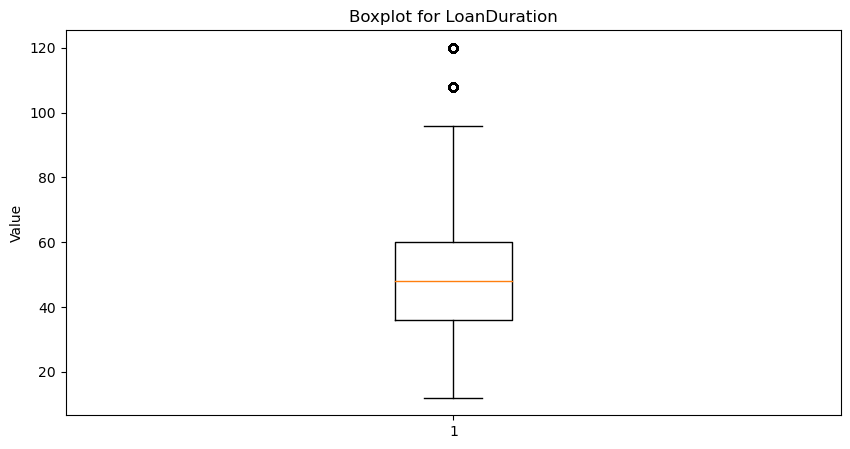

Descriptive statistics:


count    10000.000000
mean        53.386800
std         24.437031
min         12.000000
25%         36.000000
50%         48.000000
75%         60.000000
max        120.000000
Name: LoanDuration, dtype: float64


Analysis for column: NumberOfDependents


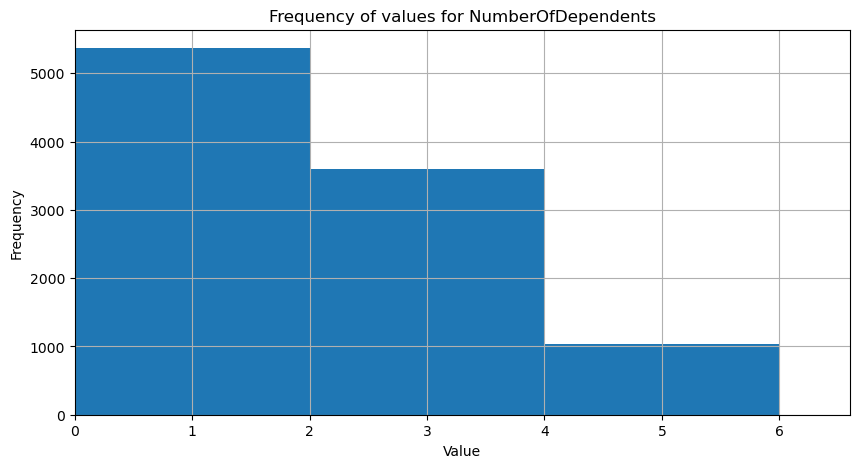

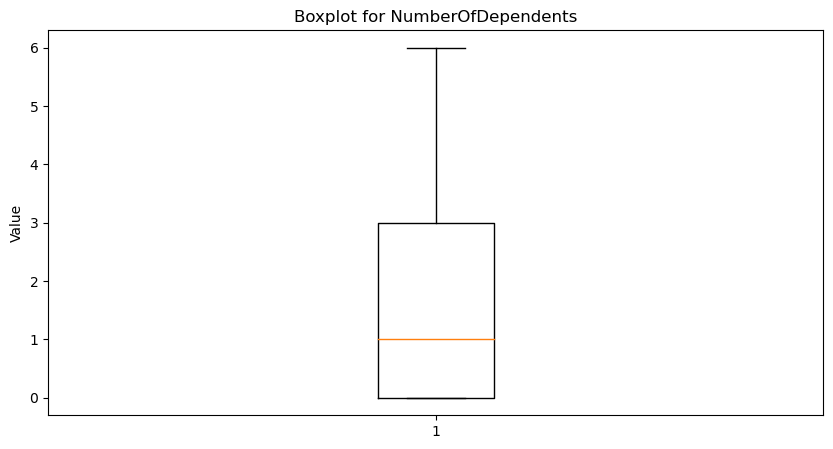

Descriptive statistics:


count    10000.000000
mean         1.566600
std          1.420058
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max          6.000000
Name: NumberOfDependents, dtype: float64


Analysis for column: MonthlyDebtPayments


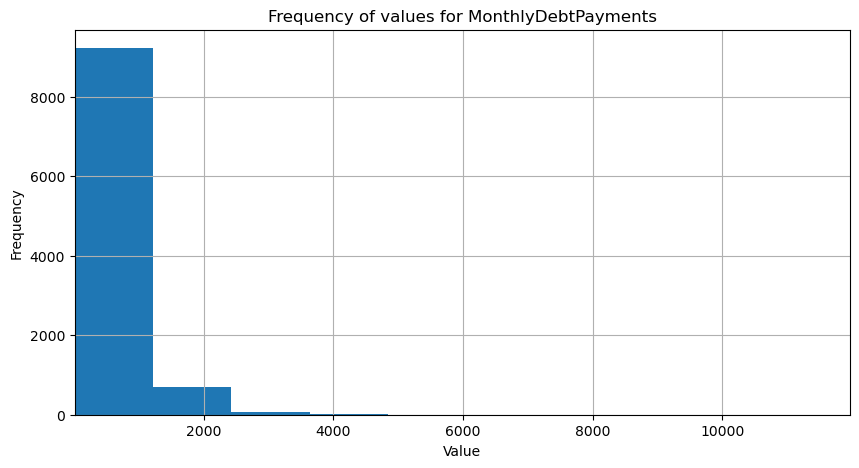

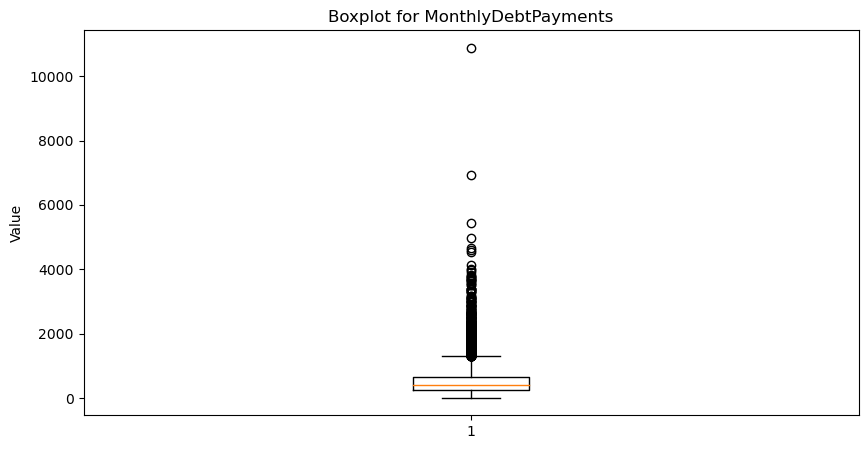

Descriptive statistics:


count    10000.00000
mean       540.03310
std        491.79713
min         13.00000
25%        242.00000
50%        399.00000
75%        665.00000
max      10879.00000
Name: MonthlyDebtPayments, dtype: float64


Analysis for column: CreditCardUtilizationRate


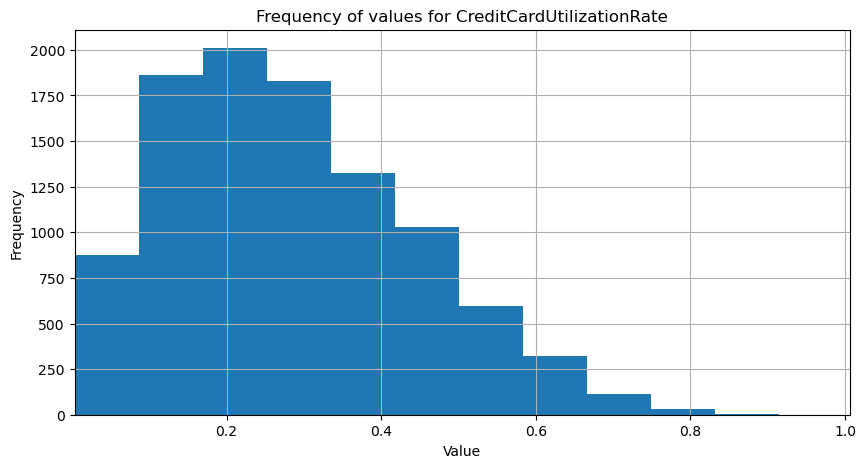

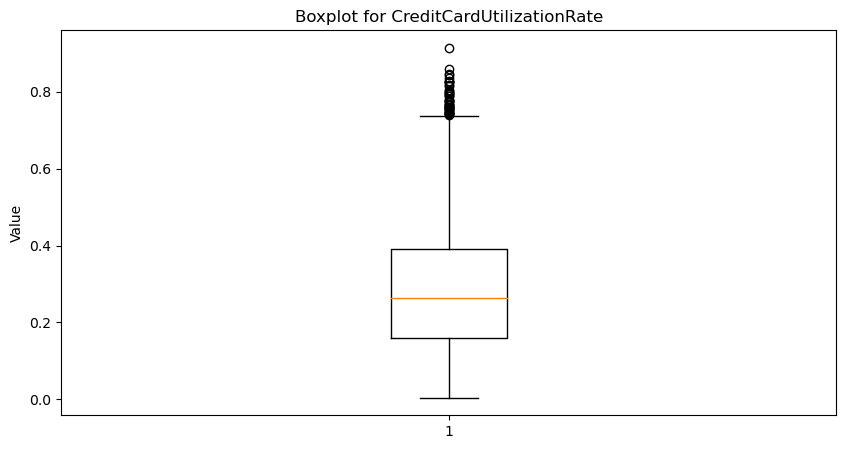

Descriptive statistics:


count    10000.000000
mean         0.284308
std          0.158935
min          0.003674
25%          0.158910
50%          0.262405
75%          0.391387
max          0.914635
Name: CreditCardUtilizationRate, dtype: float64


Analysis for column: NumberOfOpenCreditLines


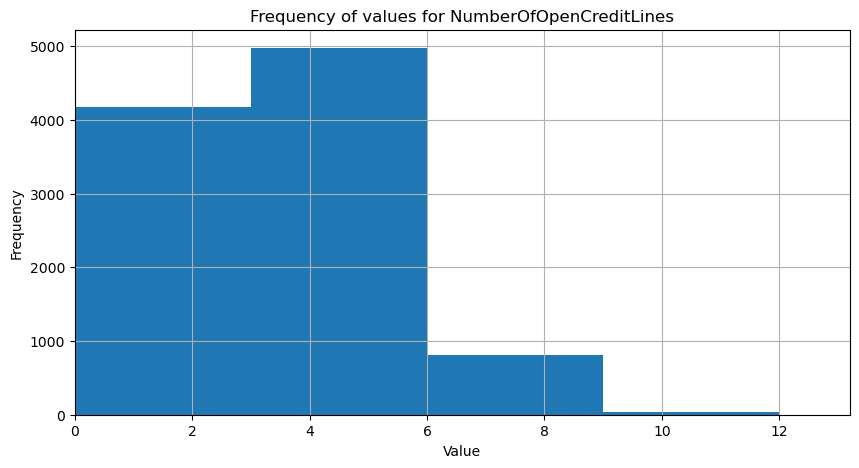

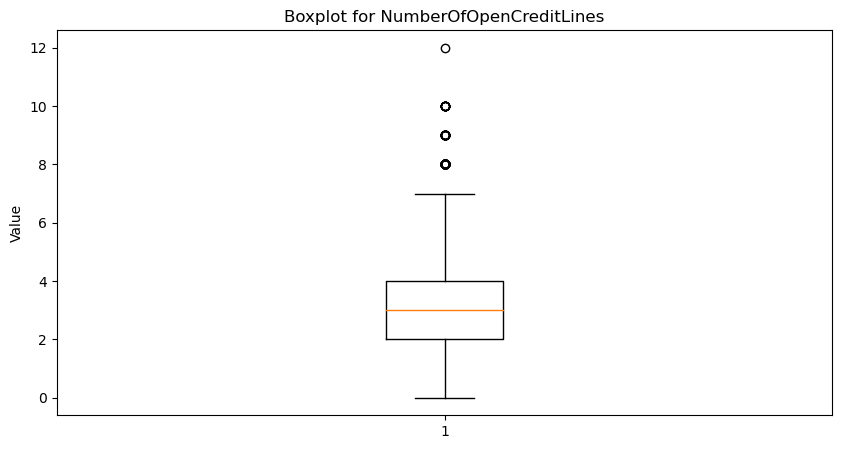

Descriptive statistics:


count    10000.000000
mean         3.036200
std          1.739768
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         12.000000
Name: NumberOfOpenCreditLines, dtype: float64


Analysis for column: NumberOfCreditInquiries


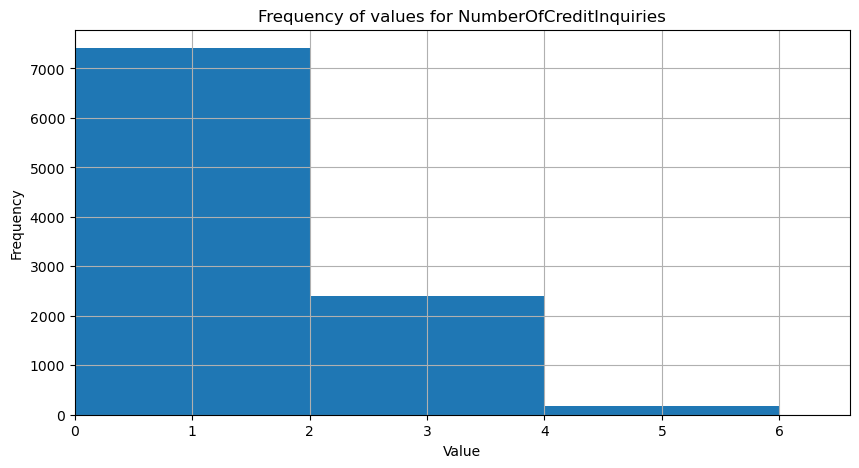

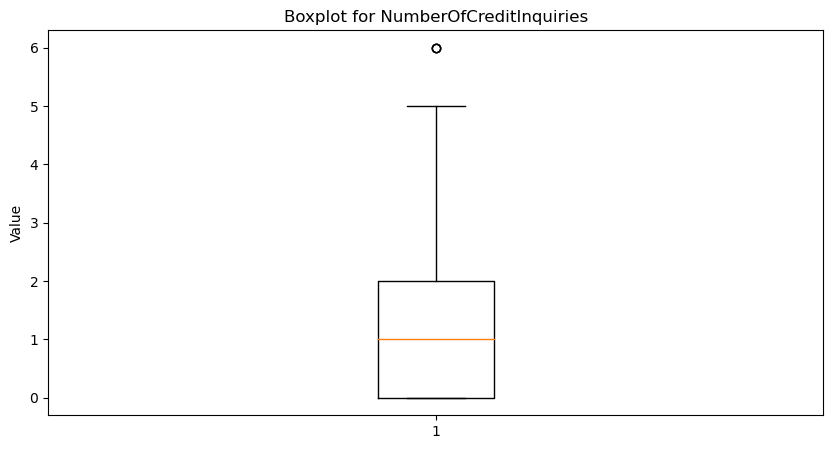

Descriptive statistics:


count    10000.000000
mean         0.981300
std          0.991992
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: NumberOfCreditInquiries, dtype: float64


Analysis for column: DebtToIncomeRatio


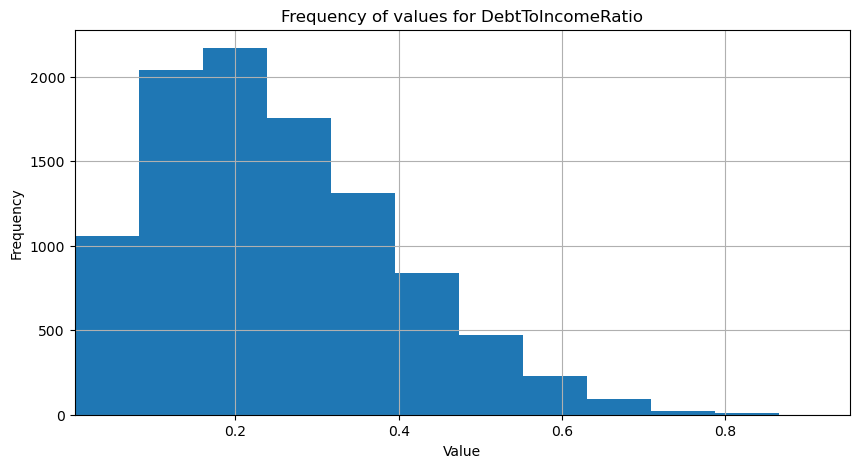

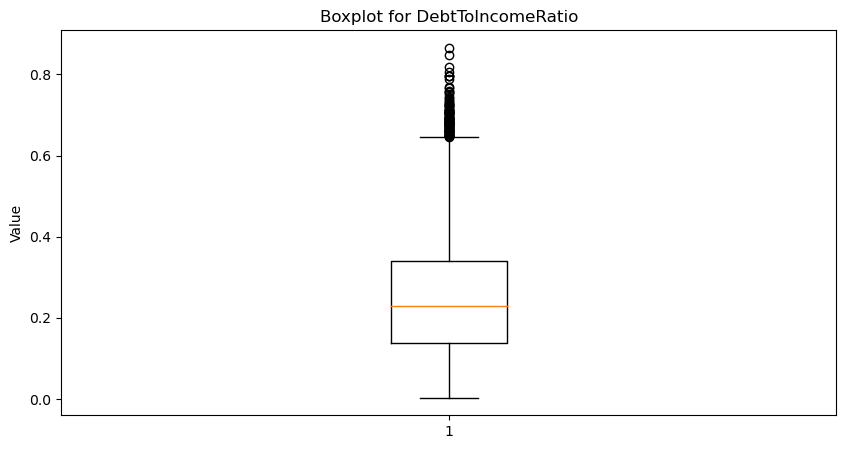

Descriptive statistics:


count    10000.000000
mean         0.250744
std          0.144692
min          0.003227
25%          0.138406
50%          0.228637
75%          0.341322
max          0.865842
Name: DebtToIncomeRatio, dtype: float64


Analysis for column: BankruptcyHistory


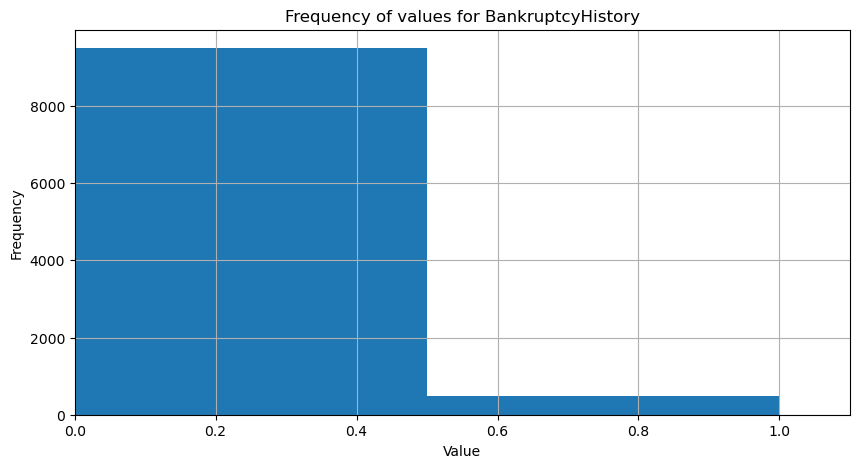

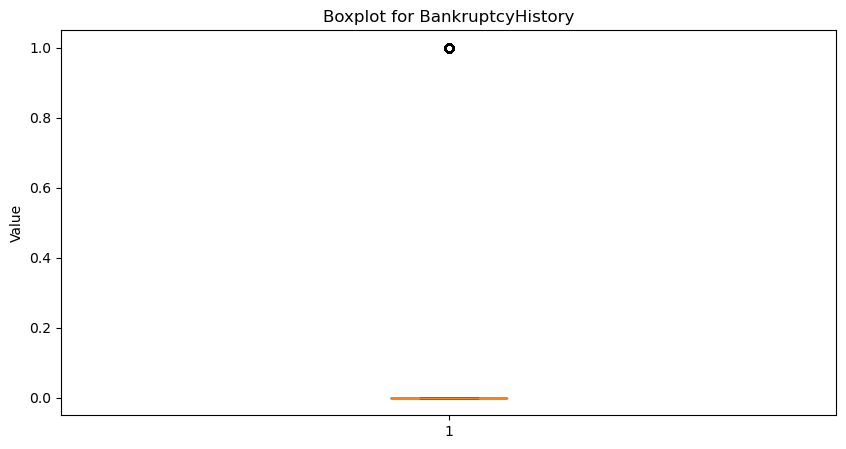

Descriptive statistics:


count    10000.000000
mean         0.049700
std          0.217335
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: BankruptcyHistory, dtype: float64


Analysis for column: PreviousLoanDefaults


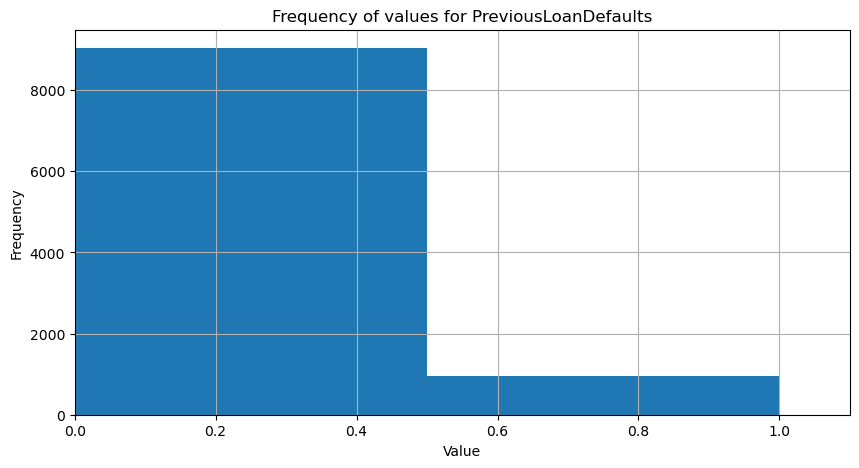

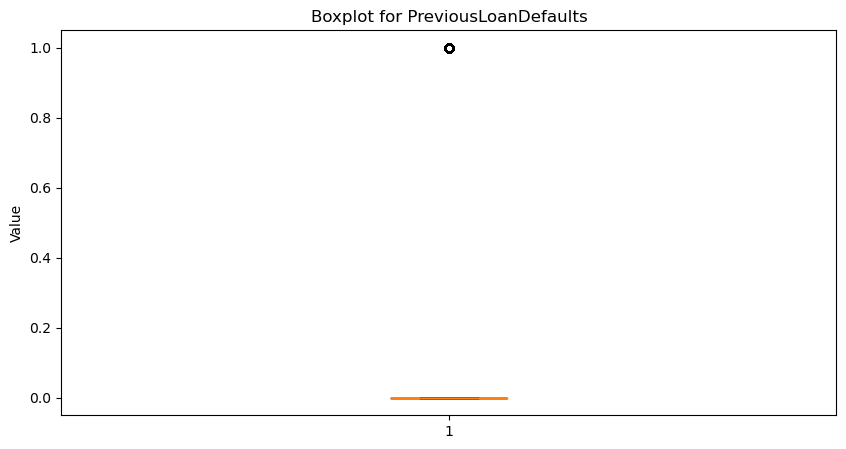

Descriptive statistics:


count    10000.000000
mean         0.096300
std          0.295017
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: PreviousLoanDefaults, dtype: float64


Analysis for column: PaymentHistory


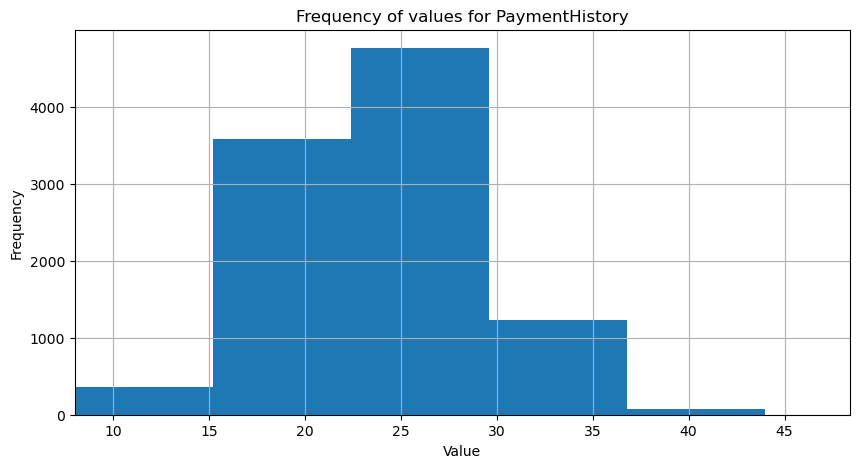

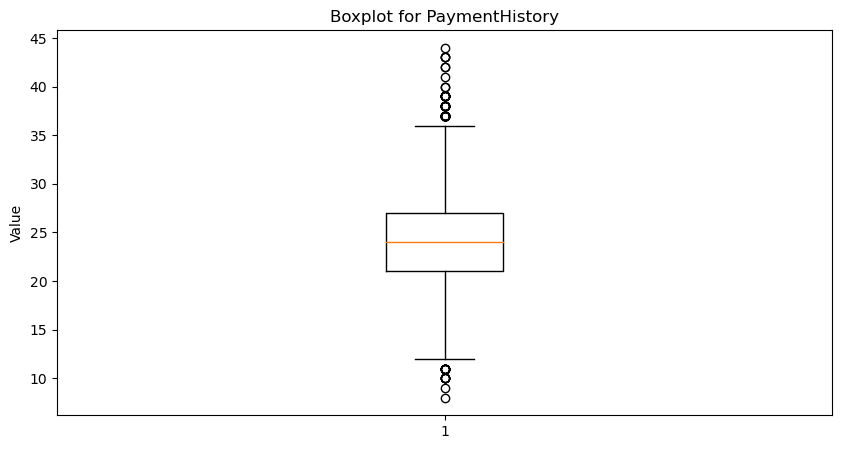

Descriptive statistics:


count    10000.00000
mean        24.00390
std          4.84855
min          8.00000
25%         21.00000
50%         24.00000
75%         27.00000
max         44.00000
Name: PaymentHistory, dtype: float64


Analysis for column: LengthOfCreditHistory


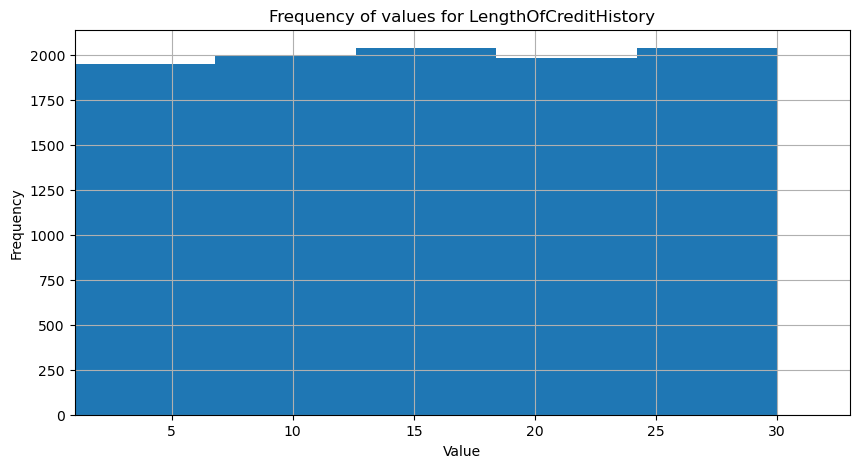

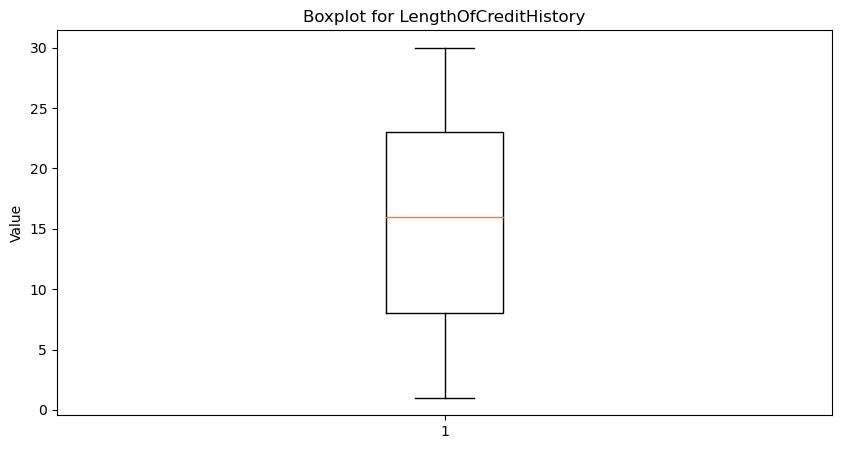

Descriptive statistics:


count    10000.000000
mean        15.639600
std          8.660717
min          1.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         30.000000
Name: LengthOfCreditHistory, dtype: float64


Analysis for column: SavingsAccountBalance


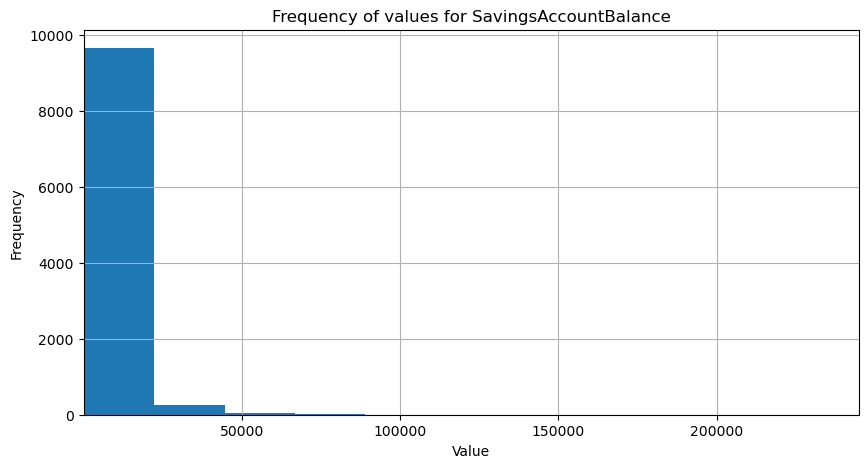

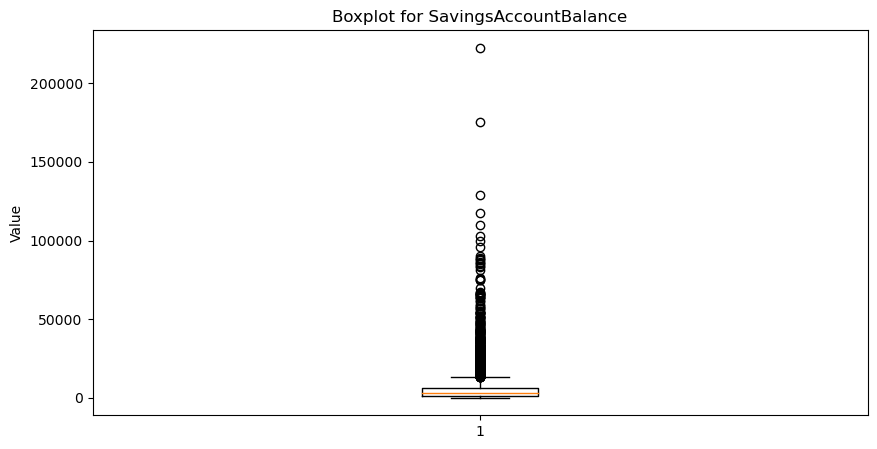

Descriptive statistics:


count     10000.000000
mean       5487.365700
std        8442.192047
min          31.000000
25%        1397.000000
50%        2967.000000
75%        6244.250000
max      222556.000000
Name: SavingsAccountBalance, dtype: float64


Analysis for column: CheckingAccountBalance


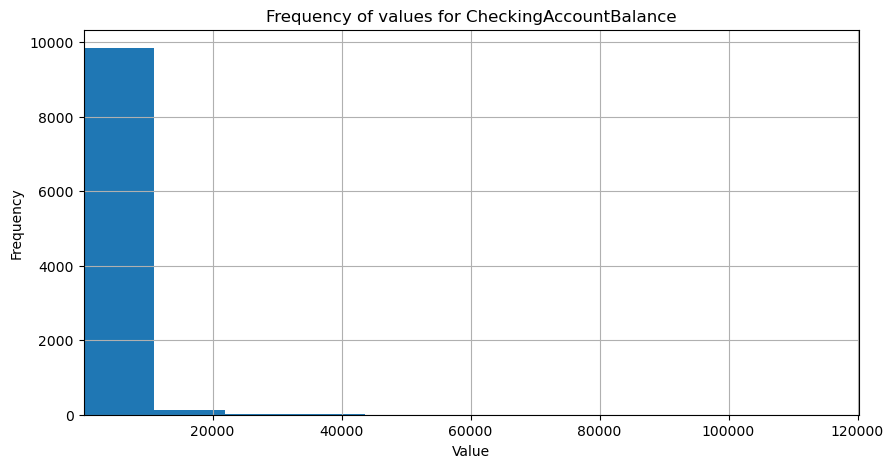

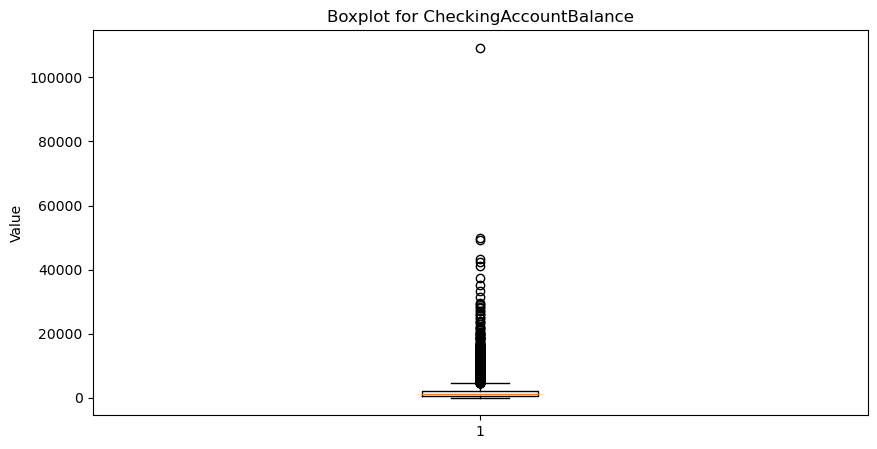

Descriptive statistics:


count     10000.000000
mean       1941.507900
std        2955.059657
min          16.000000
25%         555.000000
50%        1123.000000
75%        2211.250000
max      109245.000000
Name: CheckingAccountBalance, dtype: float64


Analysis for column: TotalAssets


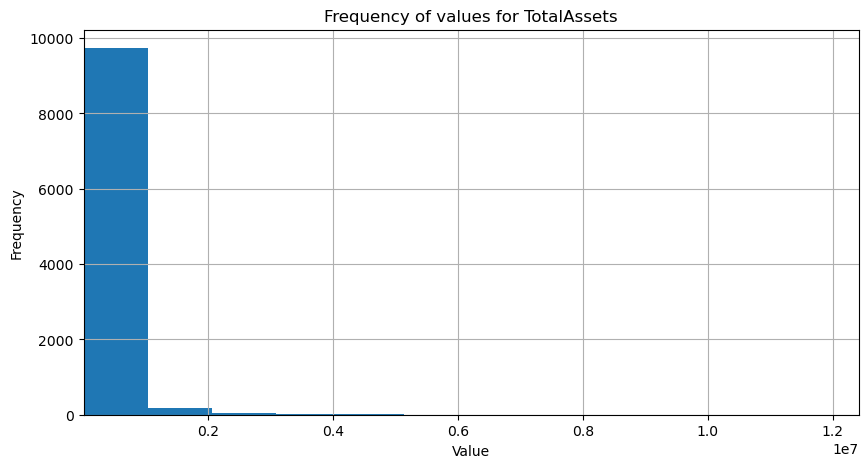

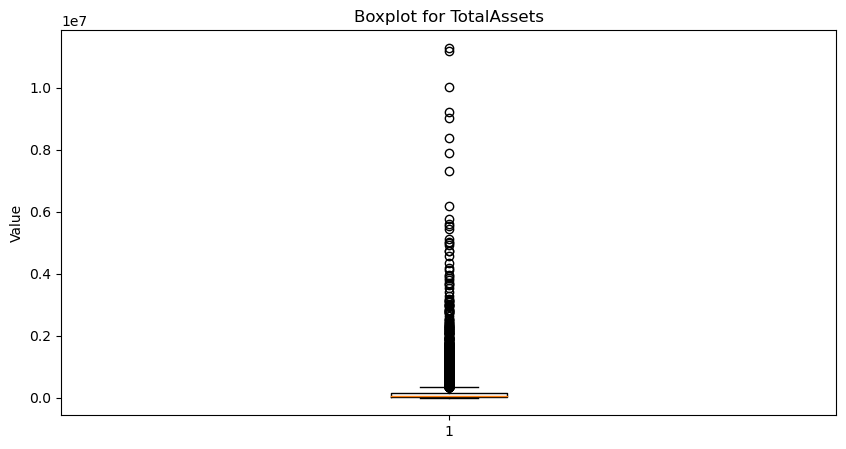

Descriptive statistics:


count    1.000000e+04
mean     1.765796e+05
std      4.522024e+05
min      8.920000e+02
25%      2.432050e+04
50%      6.095100e+04
75%      1.528322e+05
max      1.128946e+07
Name: TotalAssets, dtype: float64


Analysis for column: TotalLiabilities


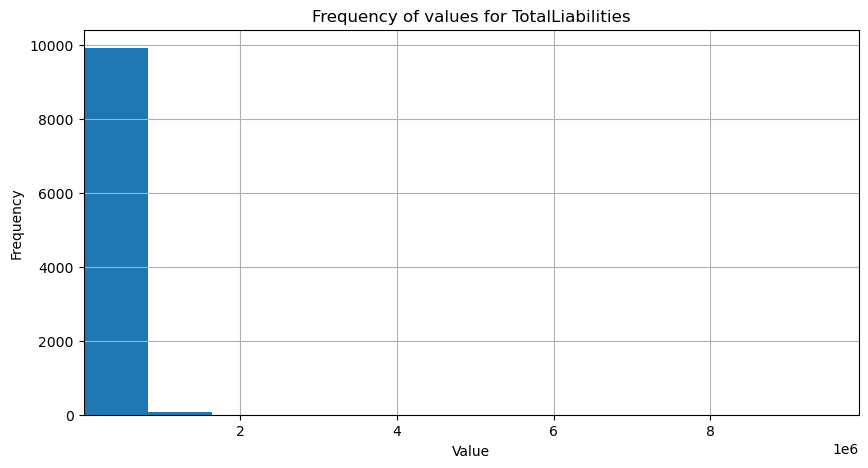

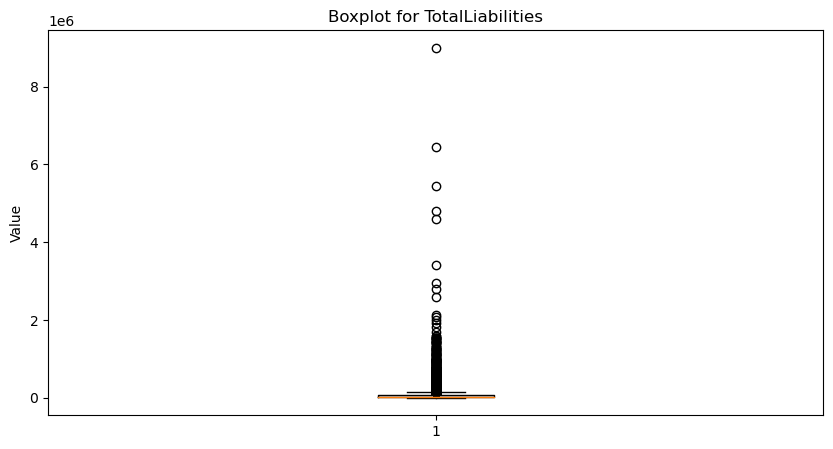

Descriptive statistics:


count    1.000000e+04
mean     6.902759e+04
std      2.059919e+05
min      7.800000e+01
25%      7.994250e+03
50%      2.260700e+04
75%      5.962925e+04
max      8.997054e+06
Name: TotalLiabilities, dtype: float64


Analysis for column: MonthlyIncome


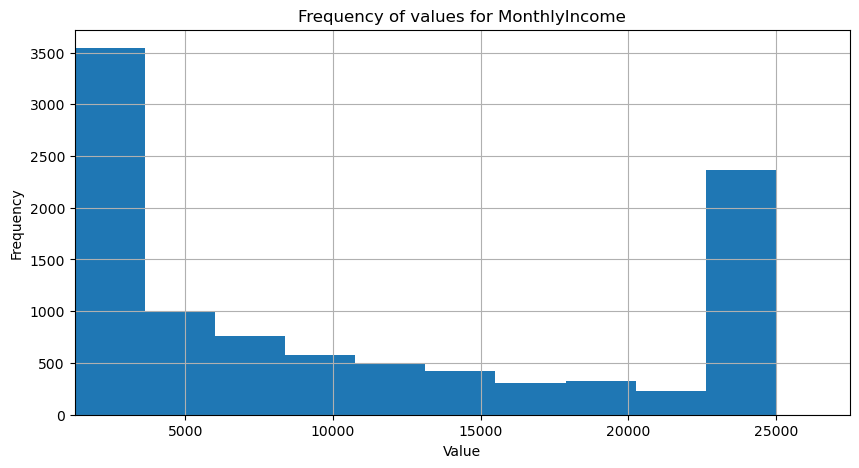

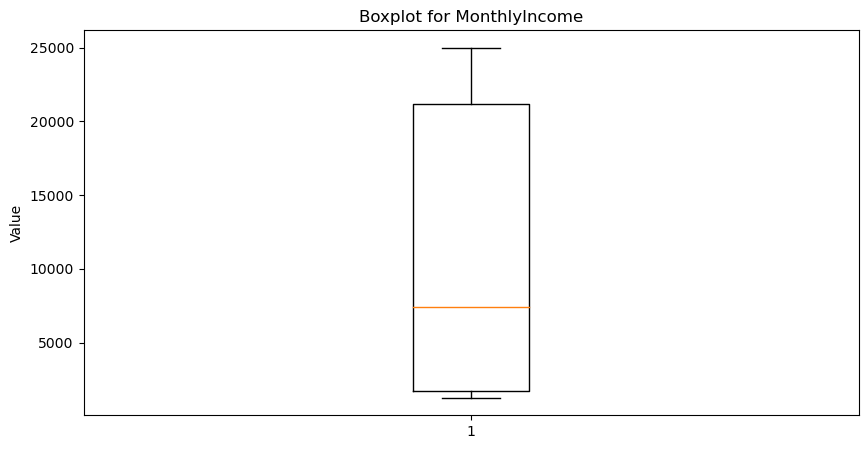

Descriptive statistics:


count    10000.000000
mean     10841.604567
std       9372.817893
min       1250.000000
25%       1721.041667
50%       7407.125000
75%      21191.875000
max      25000.000000
Name: MonthlyIncome, dtype: float64


Analysis for column: UtilityBillsPaymentHistory


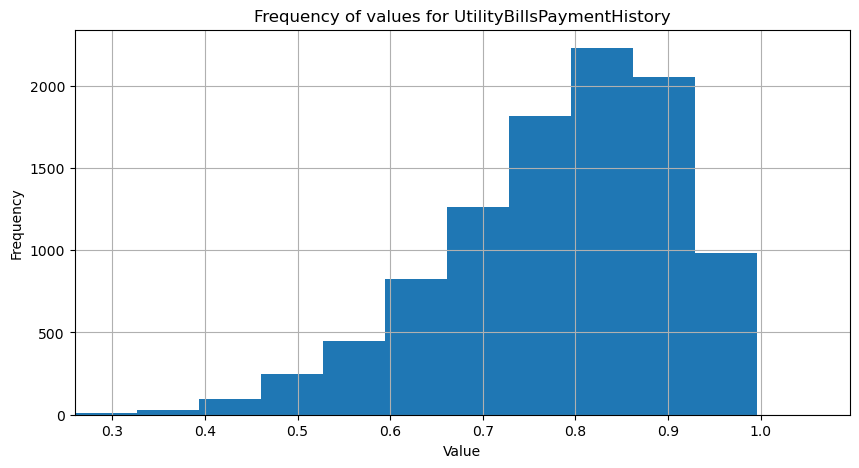

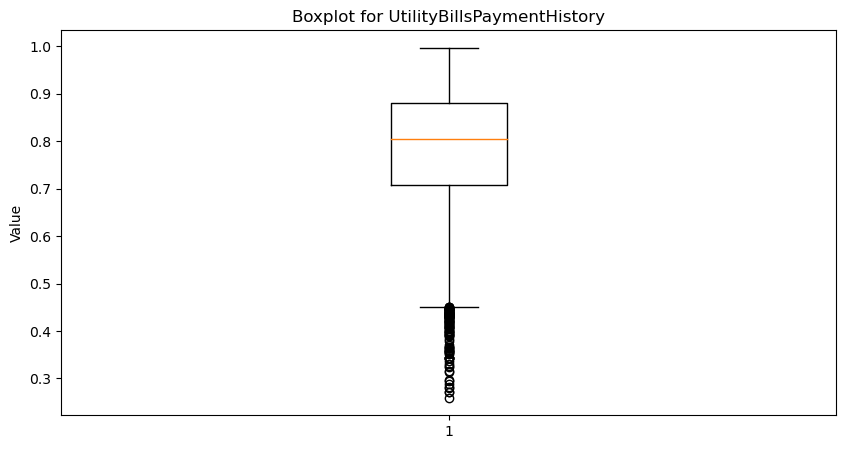

Descriptive statistics:


count    10000.000000
mean         0.784243
std          0.123320
min          0.259301
25%          0.707774
50%          0.803765
75%          0.879391
max          0.996573
Name: UtilityBillsPaymentHistory, dtype: float64


Analysis for column: JobTenure


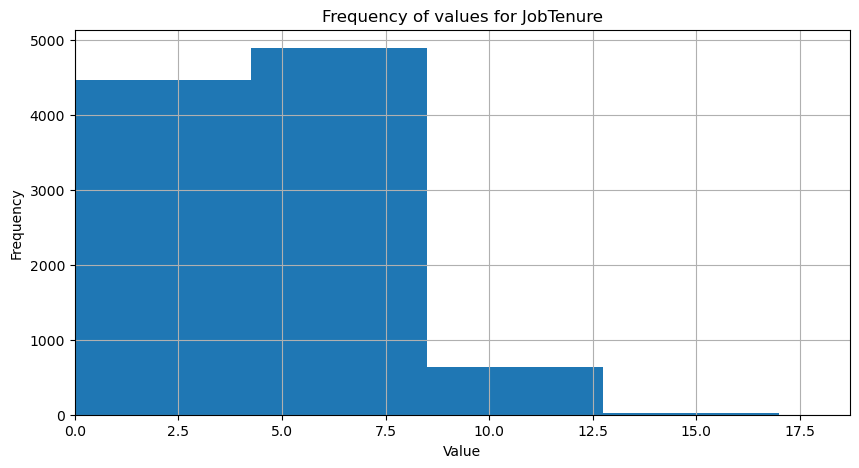

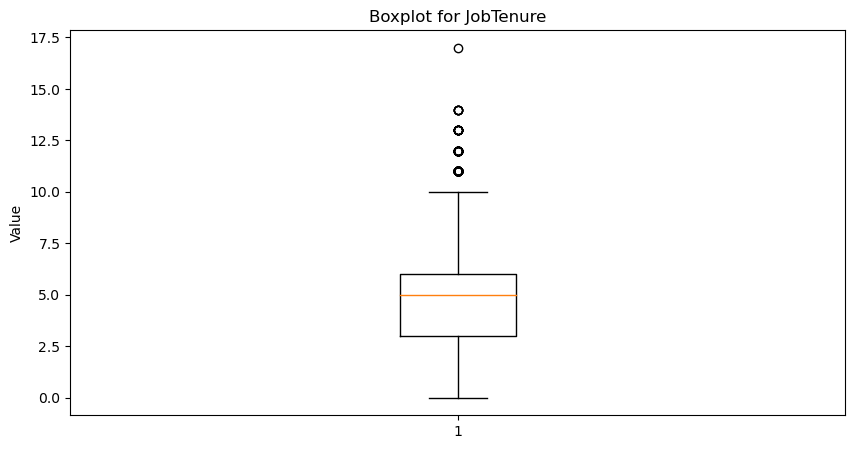

Descriptive statistics:


count    10000.000000
mean         4.961700
std          2.206291
min          0.000000
25%          3.000000
50%          5.000000
75%          6.000000
max         17.000000
Name: JobTenure, dtype: float64


Analysis for column: Experience


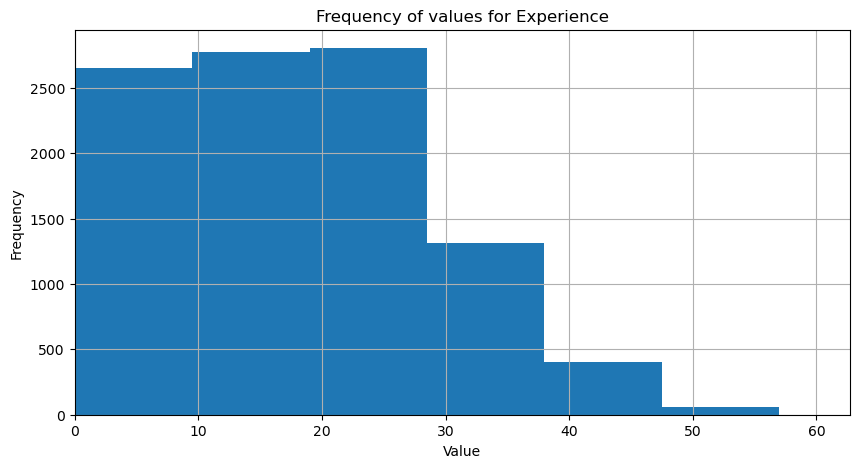

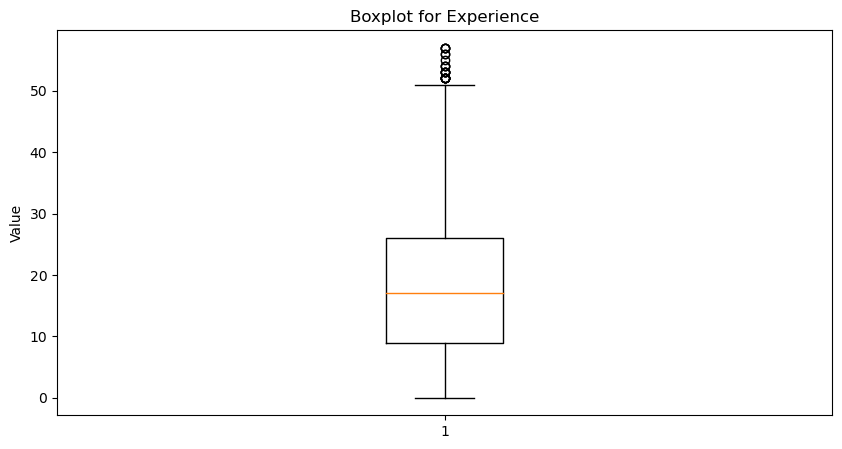

Descriptive statistics:


count    10000.000000
mean        17.616600
std         11.321882
min          0.000000
25%          9.000000
50%         17.000000
75%         26.000000
max         57.000000
Name: Experience, dtype: float64


Analysis for column: NetWorth


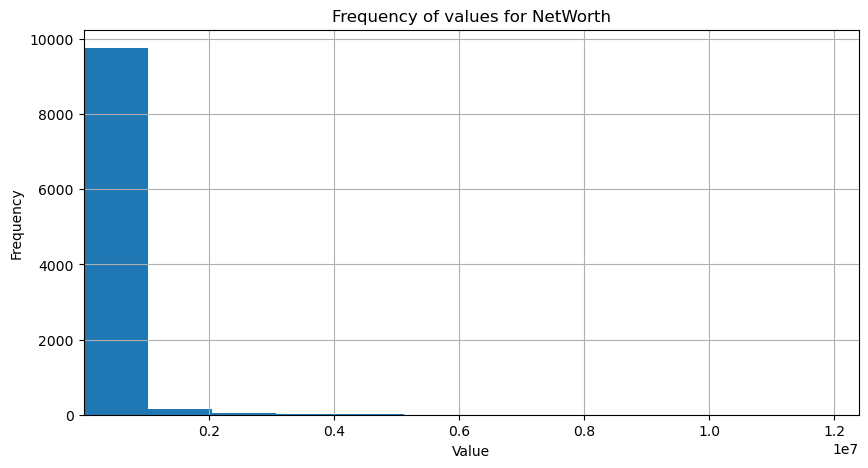

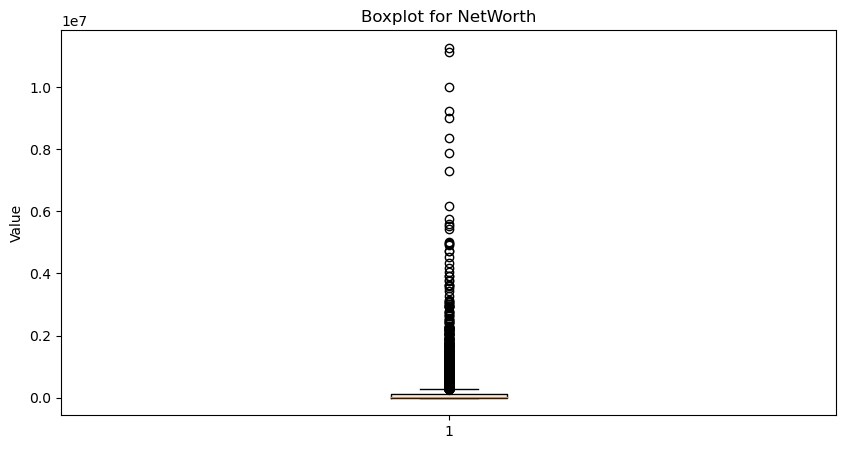

Descriptive statistics:


count    1.000000e+04
mean     1.474590e+05
std      4.470646e+05
min      1.004000e+03
25%      7.599750e+03
50%      2.763100e+04
75%      1.145482e+05
max      1.126117e+07
Name: NetWorth, dtype: float64


Analysis for column: BaseInterestRate


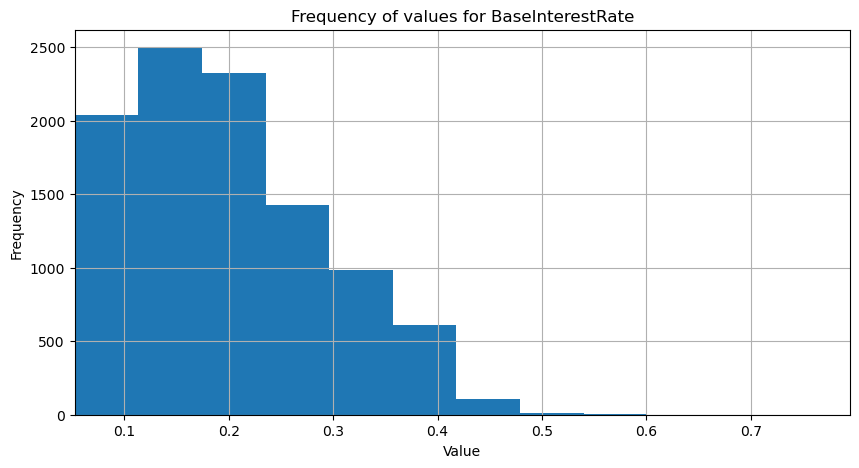

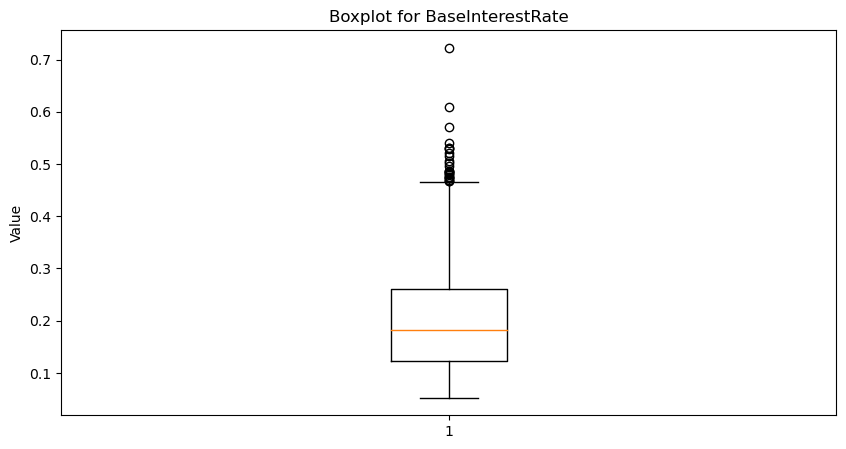

Descriptive statistics:


count    10000.000000
mean         0.199307
std          0.091786
min          0.052494
25%          0.122602
50%          0.182014
75%          0.259999
max          0.722497
Name: BaseInterestRate, dtype: float64


Analysis for column: InterestRate


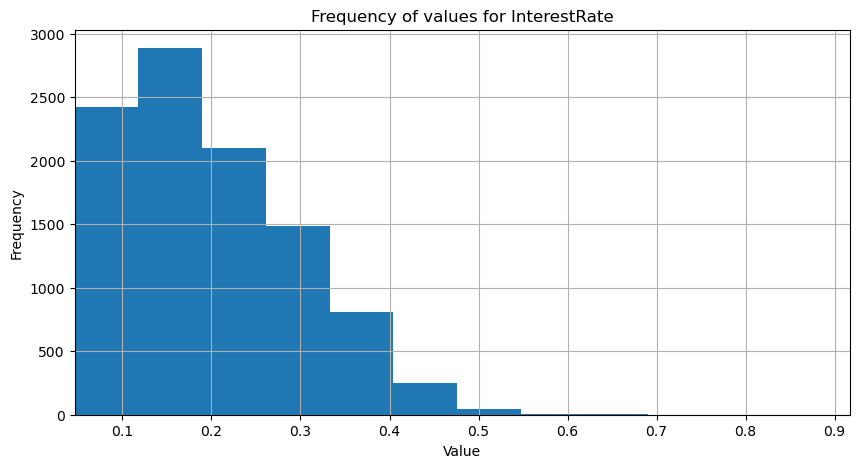

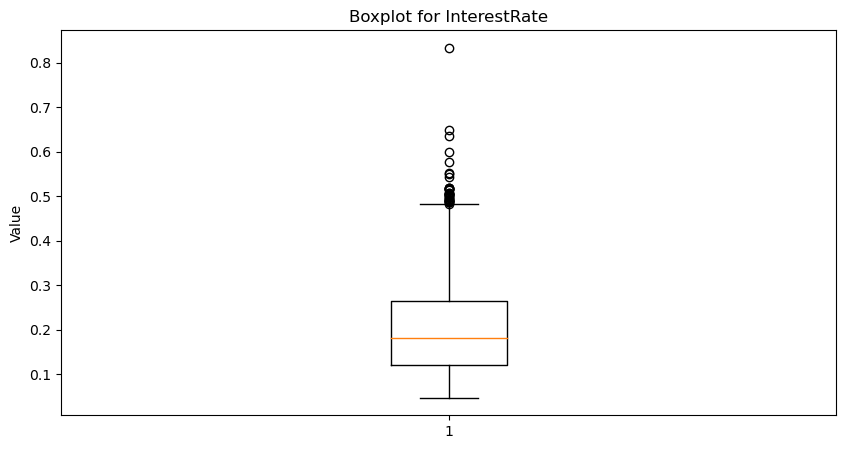

Descriptive statistics:


count    10000.000000
mean         0.199859
std          0.096039
min          0.046445
25%          0.119638
50%          0.180603
75%          0.264724
max          0.833647
Name: InterestRate, dtype: float64


Analysis for column: MonthlyLoanPayment


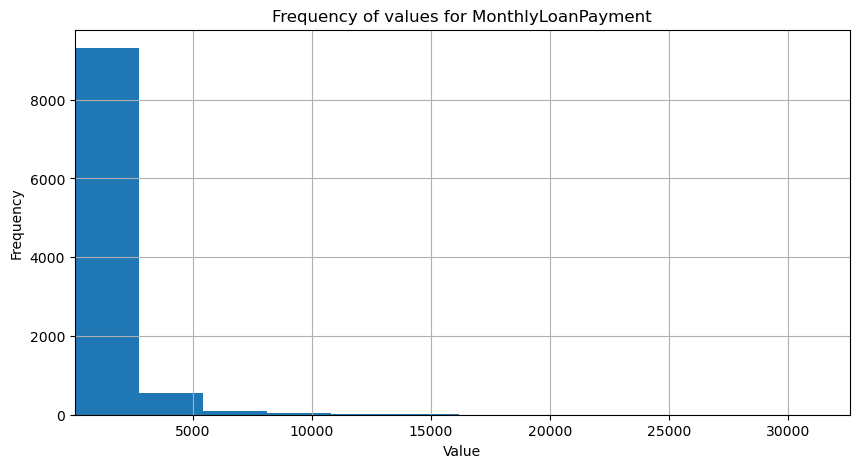

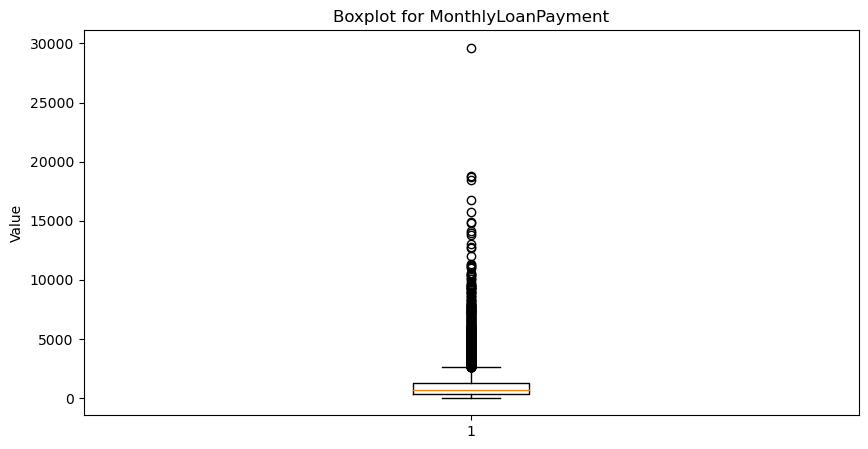

Descriptive statistics:


count    10000.000000
mean      1069.678786
std       1301.580410
min         30.008506
25%        376.055660
50%        685.884483
75%       1279.868619
max      29634.807816
Name: MonthlyLoanPayment, dtype: float64


Analysis for column: TotalDebtToIncomeRatio


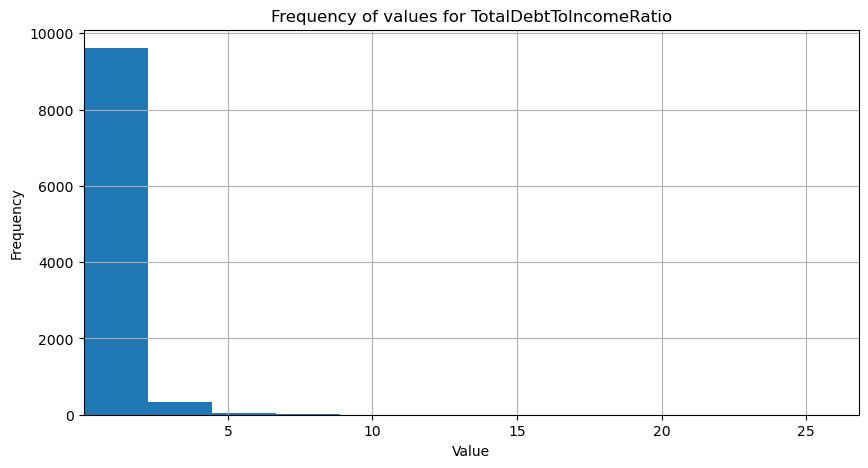

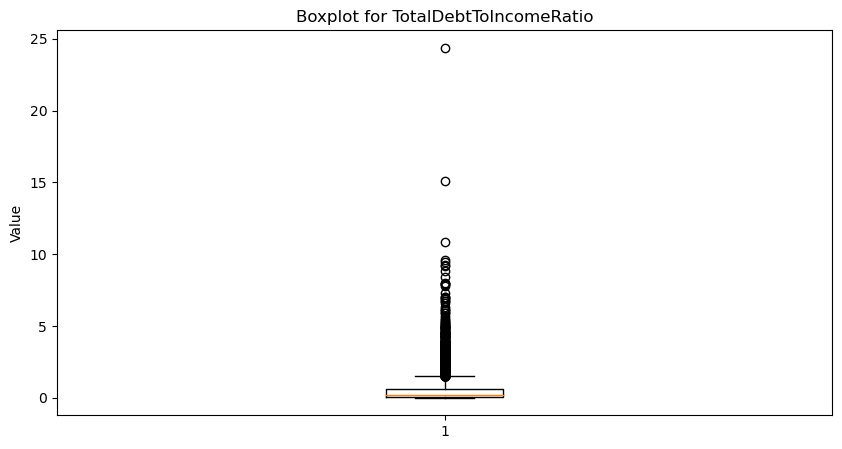

Descriptive statistics:


count    10000.000000
mean         0.510228
std          0.846362
min          0.006064
25%          0.066679
50%          0.178161
75%          0.636153
max         24.383046
Name: TotalDebtToIncomeRatio, dtype: float64


Analysis for column: LoanApproved


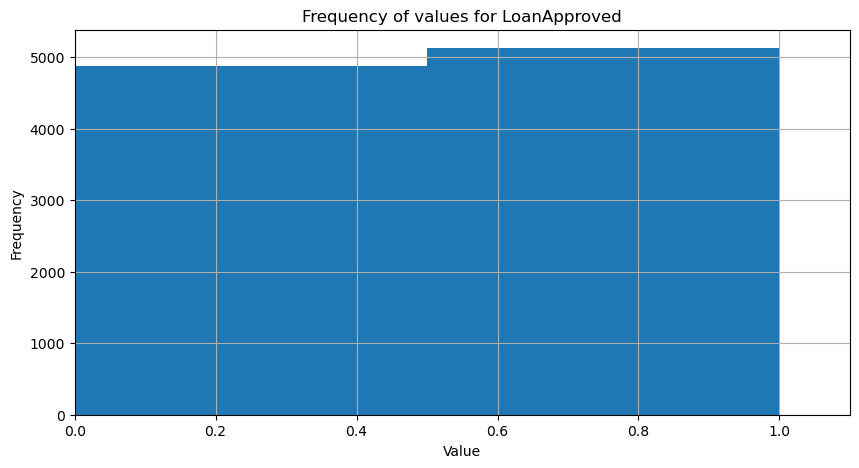

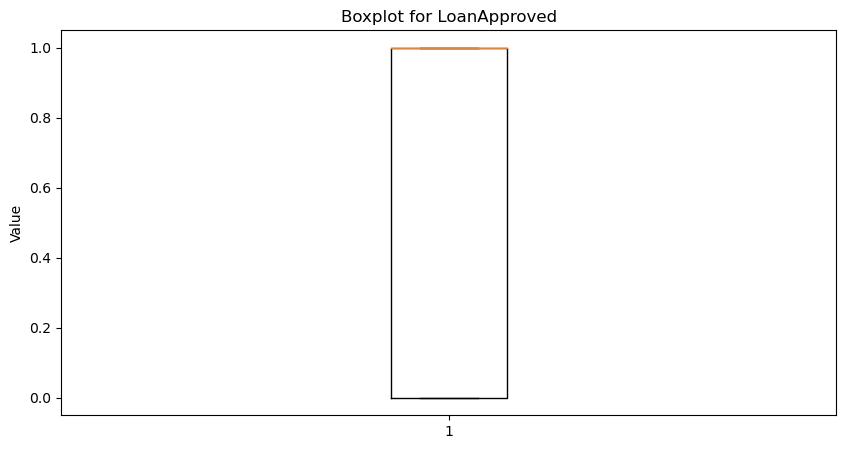

Descriptive statistics:


count    10000.000000
mean         0.512600
std          0.499866
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: LoanApproved, dtype: float64


Analysis for column: RiskScore


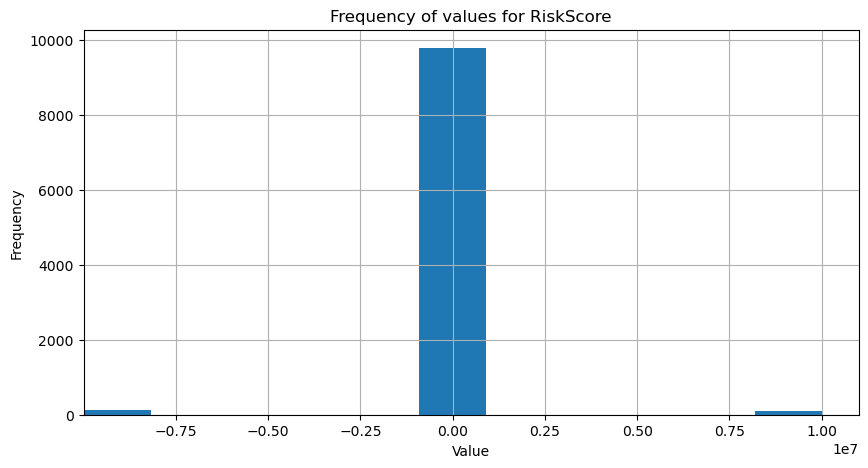

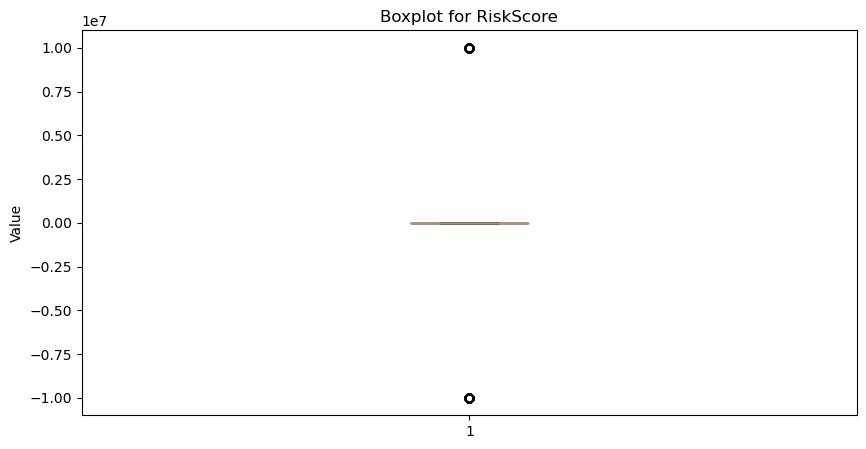

Descriptive statistics:


count    1.000000e+04
mean    -2.995269e+04
std      1.455787e+06
min     -9.999999e+06
25%      3.253485e+01
50%      4.409630e+01
75%      6.530486e+01
max      1.000000e+07
Name: RiskScore, dtype: float64

In [1116]:
for col in num_cols:
            
    print("\n" + "="*50)
    print(f"Analysis for column: {col}")
        
    plt.figure(figsize=(10, 5))
    train_df[col].hist(bins=math.ceil(np.log(len(train_df[col].unique())) + 1))
    plt.xlim(train_df[col].min(), train_df[col].max() * 1.1)
    plt.title(f"Frequency of values for {col}")
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    plt.show()
        
    plt.figure(figsize=(10, 5))
    plt.boxplot(train_df[col].dropna())
    plt.title(f"Boxplot for {col}")
    plt.ylabel('Value')
    plt.show()
        
    print("Descriptive statistics:")
    display(train_df[col].describe())

In [1117]:
Q1 = train_df['RiskScore'].quantile(0.25)
Q3 = train_df['RiskScore'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_df = train_df[(train_df['RiskScore'] >= lower_bound) & (train_df['RiskScore'] <= upper_bound)]
train_df['RiskScore'].describe()

count    9788.000000
mean       48.325333
std        17.233659
min        14.841417
25%        32.717486
50%        44.180868
75%        65.090711
max        97.597249
Name: RiskScore, dtype: float64

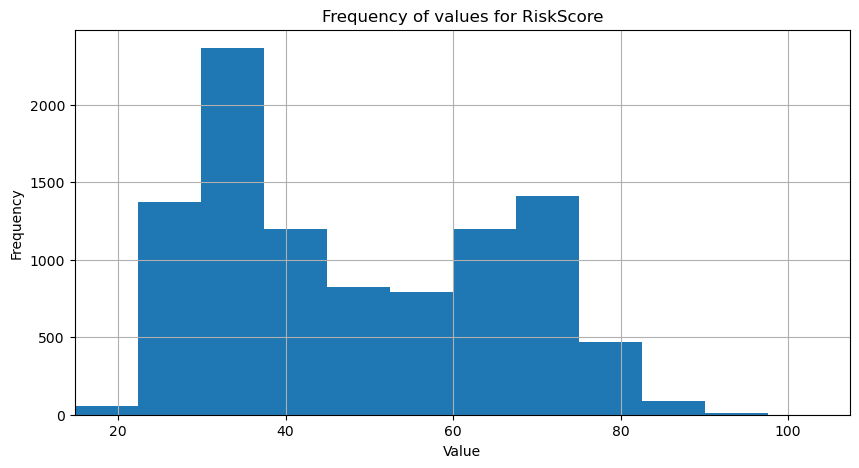

In [1118]:
plt.figure(figsize=(10, 5))
train_df['RiskScore'].hist(bins=math.ceil(np.log(len(train_df['RiskScore'].unique())) + 1))
plt.xlim(train_df['RiskScore'].min(), train_df['RiskScore'].max() * 1.1)
plt.title(f"Frequency of values for {'RiskScore'}")
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.show()

Прологарифмируем некоторые численные столбцы для борьбы с выбросами

In [1119]:
log_cols = ['MonthlyLoanPayment', 'TotalAssets', 'TotalLiabilities', 'NetWorth', 'LoanAmount', 'MonthlyDebtPayments', 'SavingsAccountBalance', 'CheckingAccountBalance']

for col in log_cols:
    train_df[col] = np.log1p(train_df[col])
    test_df[col] = np.log1p(test_df[col])


## Вывод по численным признакам:
- Почти везде наблюдаются выбросы, скорее вызванные редким являением некоторых клиентов: с большим балансом, с большим отрицательным риском и большим положительным
- Многие признаки скошены влево
- Избавились от выбросов в target`е

Categorical cols:

--------------------------------------------------
Analysis for column: MaritalStatus


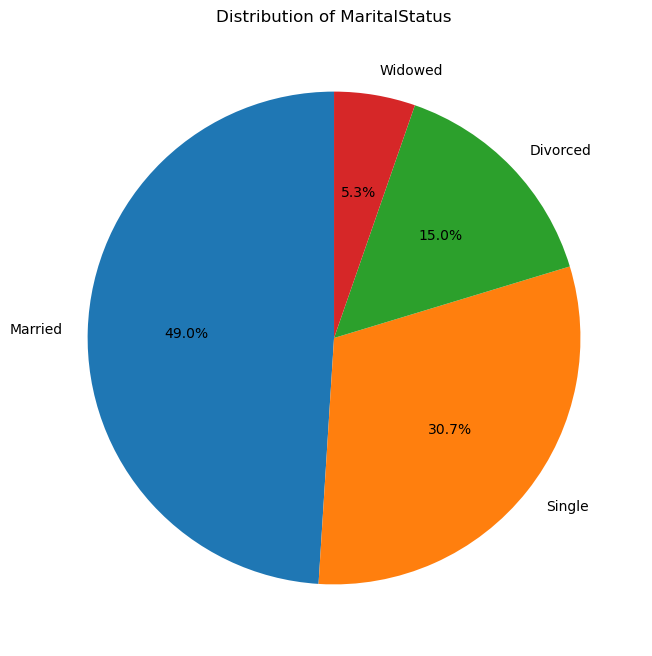

Max to min group ratio: 9.21


,Count
MaritalStatus,
Married,4796
Single,3004
Divorced,1467
Widowed,521



--------------------------------------------------
Analysis for column: HomeOwnershipStatus


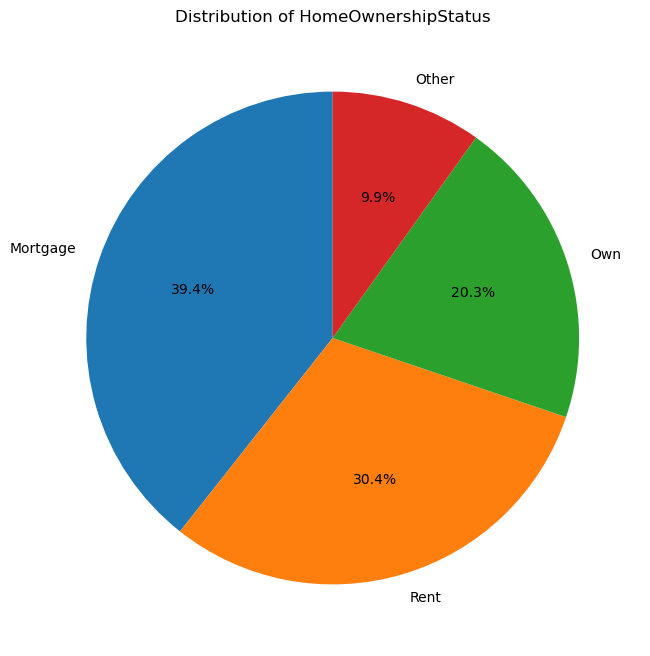

Max to min group ratio: 3.98


,Count
HomeOwnershipStatus,
Mortgage,3853
Rent,2979
Own,1989
Other,967



--------------------------------------------------
Analysis for column: LoanPurpose


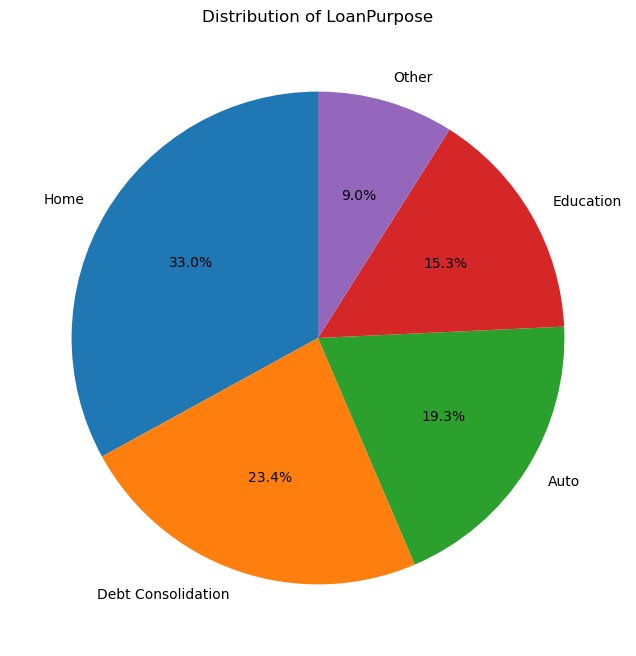

Max to min group ratio: 3.68


,Count
LoanPurpose,
Home,3229
Debt Consolidation,2294
Auto,1890
Education,1498
Other,877



--------------------------------------------------
Analysis for column: EmploymentStatus


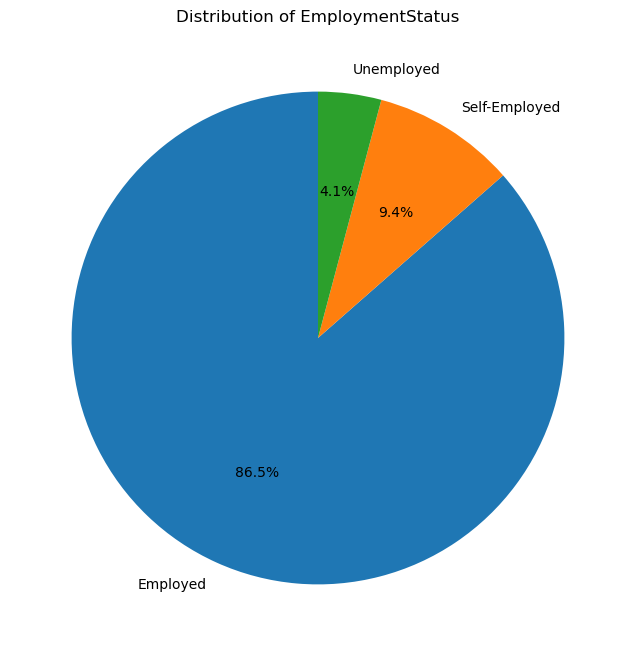

Max to min group ratio: 20.90


,Count
EmploymentStatus,
Employed,8464
Self-Employed,919
Unemployed,405



--------------------------------------------------
Analysis for column: EducationLevel


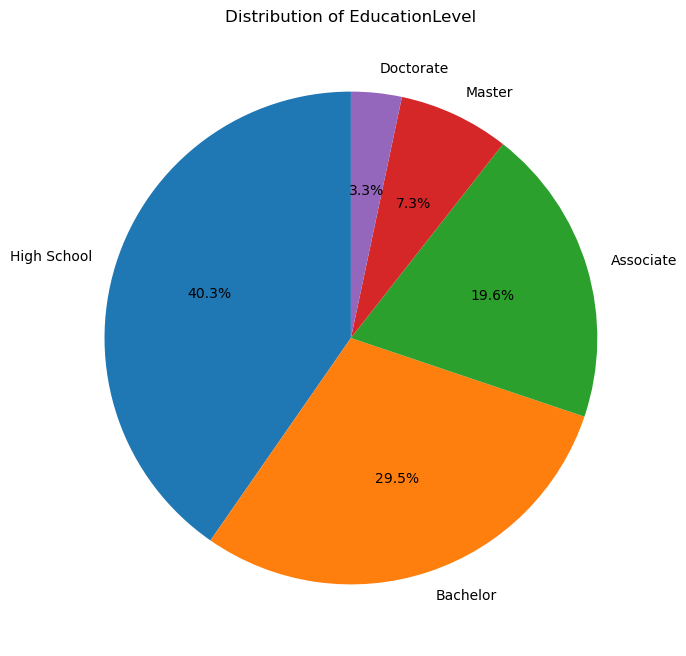

Max to min group ratio: 12.15


,Count
EducationLevel,
High School,3949
Bachelor,2886
Associate,1917
Master,711
Doctorate,325


In [1120]:
print("Categorical cols:")
for col in cat_cols:
    print("\n" + "-"*50)
    print(f"Analysis for column: {col}")
        
    value_counts = train_df[col].value_counts()
        
    plt.figure(figsize=(8, 8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f"Distribution of {col}")
    plt.show()
        
    if len(value_counts) > 1:
        ratio = value_counts.max() / value_counts.min()
        print(f"Max to min group ratio: {ratio:.2f}")
    else:
        print("Only one category exists")
        
    display(value_counts.to_frame(name='Count'))
    

## Вывод по категориальным признакам:
- Большинство клиентов женаты
- Большинство людей либо взяли жилье в ипотеку, либо арендуют
- Большинство кредитов либо на жилье либо консолидация долга
- Большая часть клиентов имеют работу
- Примерно 40% клиентов закончили школу, но не пошли в институт

## Корреляционная матрица

Для начала заменим временной признак, разложим на год, месяц и день

In [1121]:
def replace_datetime(df):
    df = df.copy()
    
    df['ApplicationYear'] = df['ApplicationDate'].dt.year
    df['ApplicationMonth'] = df['ApplicationDate'].dt.month
    df['ApplicationDay'] = df['ApplicationDate'].dt.day
    
    df = df.drop('ApplicationDate', axis=1)
    
    return df

In [1122]:
train_df = replace_datetime(train_df)
test_df = replace_datetime(test_df)

In [1123]:
train_df.head()

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,...,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore,ApplicationYear,ApplicationMonth,ApplicationDay
0,27.0,66829.0,549.0,9.757941,60.0,Divorced,1.0,Rent,6.999422,0.151985,...,10.465044,0.257790,0.251465,6.234352,0.288013,0.0,66.176500,2010,6,26
1,55.0,172147.0,850.0,9.687258,36.0,Widowed,1.0,Mortgage,5.356586,0.175693,...,10.203666,0.086110,0.093173,6.245478,0.050585,1.0,28.495737,1996,9,23
2,51.0,300000.0,850.0,10.556776,36.0,Married,0.0,Mortgage,6.304449,0.444605,...,12.536753,0.108436,0.115443,7.146202,0.072571,1.0,34.488104,2015,1,19
3,25.0,34683.0,847.0,9.861988,48.0,Married,0.0,Other,5.036953,0.188452,...,9.129672,0.100686,0.112822,6.213618,0.225415,1.0,36.910753,1981,5,12
4,55.0,300000.0,850.0,10.323447,48.0,Single,2.0,Rent,6.333280,0.273431,...,8.412499,0.110437,0.089037,6.629410,0.052721,1.0,31.347091,1995,5,7


In [1124]:
num_cols = train_df.select_dtypes(include=['number']).columns
num_cols

Index(['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration',
       'NumberOfDependents', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
       'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory',
       'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate',
       'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio',
       'LoanApproved', 'RiskScore', 'ApplicationYear', 'ApplicationMonth',
       'ApplicationDay'],
      dtype='object')

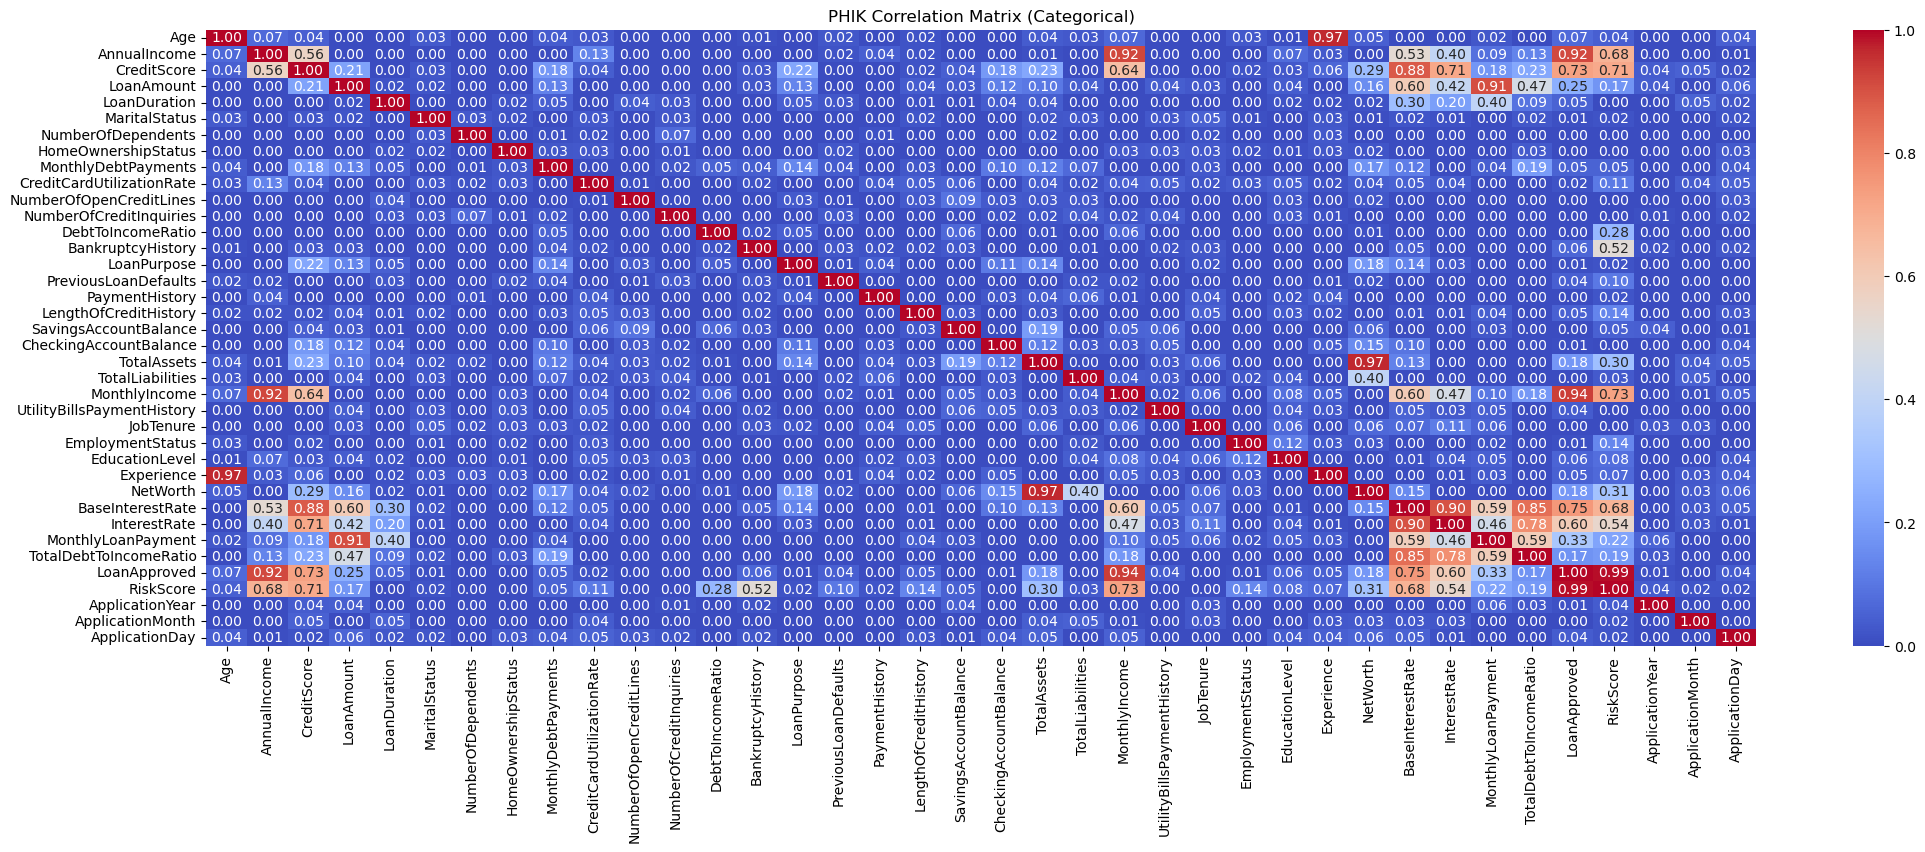

In [1125]:
phik_matrix = train_df.phik_matrix(interval_cols=list(num_cols))

fig, axes = plt.subplots(figsize=(25, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=axes)
plt.title('PHIK Correlation Matrix (Categorical)')

plt.show()

## Feature engineering

Напишем пайплайн для отбора и обработки признаков

In [1126]:
mlflow.set_experiment('Feature selection and engineering')

<Experiment: artifact_location='s3://mlops-check/mlflow/690470679808536648', creation_time=1746625572801, experiment_id='690470679808536648', last_update_time=1746625572801, lifecycle_stage='active', name='Feature selection and engineering', tags={}>

In [1127]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures

class FeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, log=True, square=True, interactions=True):
        self.log = log
        self.square = square
        self.interactions = interactions
        self.poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        self.feature_names_in_ = None
        self.numeric_cols_ = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.tolist()
            self.numeric_cols_ = X.select_dtypes(include=[np.number]).columns.tolist()
        else:
            self.feature_names_in_ = [f'x{i}' for i in range(X.shape[1])]
            self.numeric_cols_ = self.feature_names_in_
        
        if self.interactions:
            self.poly.fit(X[self.numeric_cols_] if isinstance(X, pd.DataFrame) else X)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        
        results = [X.copy()]
        
        numeric_cols = self.numeric_cols_ if hasattr(self, 'numeric_cols_') else X.select_dtypes(include=[np.number]).columns
        
        if self.square and len(numeric_cols) > 0:
            X_square = X[numeric_cols] ** 2
            X_square.columns = [f'{col}_squared' for col in X_square.columns]
            results.append(X_square)

        if self.log and len(numeric_cols) > 0:
            X_log = np.log1p(np.abs(X[numeric_cols]))
            X_log.columns = [f'{col}_log' for col in X_log.columns]
            results.append(X_log)

        if self.interactions and len(numeric_cols) > 1:
            X_poly = self.poly.transform(X[numeric_cols])
            poly_cols = self.poly.get_feature_names_out(numeric_cols)
            X_poly_df = pd.DataFrame(X_poly, columns=poly_cols, index=X.index)
            
            interaction_cols = [col for col in poly_cols if " " in col]
            interaction_df = X_poly_df[interaction_cols]
            interaction_df.columns = [col.replace(" ", "_x_") for col in interaction_cols]
            
            results.append(interaction_df)

        return pd.concat(results, axis=1)

In [1128]:
X_train = train_df.drop(columns = ['RiskScore'], axis = 1)
y_train = train_df['RiskScore']

f_gen = FeatureGenerator(log=True, square=True, interactions=True)
f_gen.fit(X_train)

X_train_gen = f_gen.fit_transform(X_train)
X_test_gen = f_gen.transform(test_df)

In [1129]:
X_test_gen

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,...,TotalDebtToIncomeRatio_x_LoanApproved,TotalDebtToIncomeRatio_x_ApplicationYear,TotalDebtToIncomeRatio_x_ApplicationMonth,TotalDebtToIncomeRatio_x_ApplicationDay,LoanApproved_x_ApplicationYear,LoanApproved_x_ApplicationMonth,LoanApproved_x_ApplicationDay,ApplicationYear_x_ApplicationMonth,ApplicationYear_x_ApplicationDay,ApplicationMonth_x_ApplicationDay
0,49,207095,850,9.579072,60,Single,0,Rent,5.932245,0.077124,...,0.040650,80.446123,0.040650,0.121950,1979.0,1.0,3.0,1979.0,5937.0,3.0
1,28,64653,674,11.089683,48,Single,2,Own,5.476464,0.073977,...,0.000000,911.546564,1.817640,4.544101,0.0,0.0,0.0,8024.0,20060.0,40.0
2,41,300000,768,9.729848,60,Single,1,Own,6.152733,0.331499,...,0.034919,70.292143,0.384110,0.977735,2013.0,11.0,28.0,22143.0,56364.0,308.0
3,50,300000,850,10.794214,36,Divorced,0,Mortgage,6.342121,0.544696,...,0.085558,170.687963,0.684463,2.053389,1995.0,8.0,24.0,15960.0,47880.0,192.0
4,35,300000,672,10.857402,60,Single,6,Mortgage,4.672829,0.436103,...,0.063707,126.139879,0.382242,0.955605,1980.0,6.0,15.0,11880.0,29700.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,40,300000,850,9.449121,60,Married,1,Other,6.075346,0.062521,...,0.028012,55.827529,0.084035,0.532224,1993.0,3.0,19.0,5979.0,37867.0,57.0
4996,39,75014,572,10.807321,48,Married,0,Mortgage,4.584967,0.057142,...,0.000000,606.582303,2.709301,8.127902,0.0,0.0,0.0,18135.0,54405.0,243.0
4997,43,15000,454,10.398519,72,Divorced,1,Other,5.669881,0.403643,...,0.000000,1978.221524,9.925848,3.970339,0.0,0.0,0.0,19930.0,7972.0,40.0
4998,53,98467,850,10.255798,96,Single,1,Own,5.365976,0.137445,...,0.000000,180.092055,0.454548,0.909097,0.0,0.0,0.0,9905.0,19810.0,50.0


In [1130]:
def feature_selection(X, y,
                     num_method='f_classif', cat_method='chi2',
                     correlation_threshold=0.8, 
                     top_k_num=None, top_k_cat=None):
    
    
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    
    if str(y.dtype) in ['object', 'category', 'bool']:
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
    else:
        y_encoded = y
    
    selected_features = []
    
    if numeric_cols:
        X_num = X[numeric_cols].fillna(X[numeric_cols].median())
        
        if num_method == 'f_classif':
            scores, _ = f_classif(X_num, y_encoded)
            num_scores = pd.Series(scores, index=numeric_cols)
        elif num_method == 'mutual_info':
            scores = mutual_info_classif(X_num, y_encoded, random_state=42)
            num_scores = pd.Series(scores, index=numeric_cols)
        elif num_method == 'pointbiserial':
            num_scores = pd.Series({
                col: pointbiserialr(X_num[col], y_encoded)[0] 
                for col in numeric_cols
            }).abs()
        
        if top_k_num is not None:
            num_selected = num_scores.nlargest(top_k_num).index.tolist()
        else:
            num_selected = numeric_cols
        
        selected_features.extend(num_selected)
    
    if categorical_cols:
        X_cat = X[categorical_cols].fillna('missing')
        
        if cat_method == 'chi2':
            cat_scores = pd.Series({
                col: chi2_contingency(pd.crosstab(X_cat[col], y))[0] 
                for col in categorical_cols
            })
        elif cat_method == 'mutual_info':
            X_cat_encoded = X_cat.apply(lambda x: LabelEncoder().fit_transform(x.astype(str)))
            scores = mutual_info_classif(X_cat_encoded, y_encoded, random_state=42)
            cat_scores = pd.Series(scores, index=categorical_cols)
        
        if top_k_cat is not None:
            cat_selected = cat_scores.nlargest(top_k_cat).index.tolist()
        else:
            cat_selected = categorical_cols
        
        selected_features.extend(cat_selected)
    
    if numeric_cols:
        corr_matrix = X[selected_features].select_dtypes(include=['int64', 'float64']).corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
        
        final_features = [f for f in selected_features if f not in to_drop]
    else:
        final_features = selected_features
    
    return final_features

In [1131]:
selected_features = feature_selection(
    X_train_gen, 
    y_train,
    num_method='f_classif',
    cat_method='chi2',
    correlation_threshold=0.95,
    top_k_num=75,
    top_k_cat=15
)

print("Отобранные признаки:", selected_features)

/opt/conda/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


Отобранные признаки: ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved', 'AnnualIncome_squared', 'NumberOfDependents_squared', 'NumberOfOpenCreditLines_squared', 'NumberOfCreditInquiries_squared', 'TotalDebtToIncomeRatio_squared', 'AnnualIncome_log', 'LoanDuration_log', 'LengthOfCreditHistory_log', 'LoanPurpose', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'EmploymentStatus']


In [1132]:
len(selected_features)

39

In [1133]:
X_train_gen[selected_features]

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,NumberOfCreditInquiries_squared,TotalDebtToIncomeRatio_squared,AnnualIncome_log,LoanDuration_log,LengthOfCreditHistory_log,LoanPurpose,EducationLevel,MaritalStatus,HomeOwnershipStatus,EmploymentStatus
0,27.0,66829.0,549.0,9.757941,60.0,1.0,6.999422,0.151985,2.0,1.0,...,1.0,0.082952,11.109907,4.110874,1.791759,Education,Associate,Divorced,Rent,Employed
1,55.0,172147.0,850.0,9.687258,36.0,1.0,5.356586,0.175693,3.0,0.0,...,0.0,0.002559,12.056110,3.610918,2.484907,Home,High School,Widowed,Mortgage,Employed
2,51.0,300000.0,850.0,10.556776,36.0,0.0,6.304449,0.444605,3.0,0.0,...,0.0,0.005267,12.611541,3.610918,2.564949,Education,Bachelor,Married,Mortgage,Employed
3,25.0,34683.0,847.0,9.861988,48.0,0.0,5.036953,0.188452,7.0,0.0,...,0.0,0.050812,10.454034,3.891820,3.091042,Debt Consolidation,High School,Married,Other,Employed
4,55.0,300000.0,850.0,10.323447,48.0,2.0,6.333280,0.273431,3.0,1.0,...,1.0,0.002780,12.611541,3.891820,2.302585,Debt Consolidation,Bachelor,Single,Rent,Employed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,27.0,15000.0,361.0,9.878477,36.0,1.0,6.434547,0.409411,2.0,1.0,...,1.0,1.440274,9.615872,3.610918,2.833213,Education,High School,Single,Other,Employed
9996,49.0,185082.0,573.0,8.915701,84.0,0.0,6.853299,0.095426,0.0,0.0,...,0.0,0.005343,12.128560,4.442651,3.295837,Auto,High School,Married,Mortgage,Employed
9997,55.0,296728.0,850.0,10.695643,84.0,2.0,6.173786,0.373804,6.0,0.0,...,0.0,0.002844,12.600575,4.442651,2.995732,Education,High School,Divorced,Mortgage,Employed
9998,33.0,206277.0,723.0,9.989849,24.0,0.0,5.991465,0.070873,4.0,0.0,...,0.0,0.048415,12.236980,3.218876,2.639057,Home,High School,Married,Mortgage,Self-Employed


In [1134]:
X_train_gen = X_train_gen[selected_features]

In [1135]:
X_train_gen = X_train_gen.join(y_train)

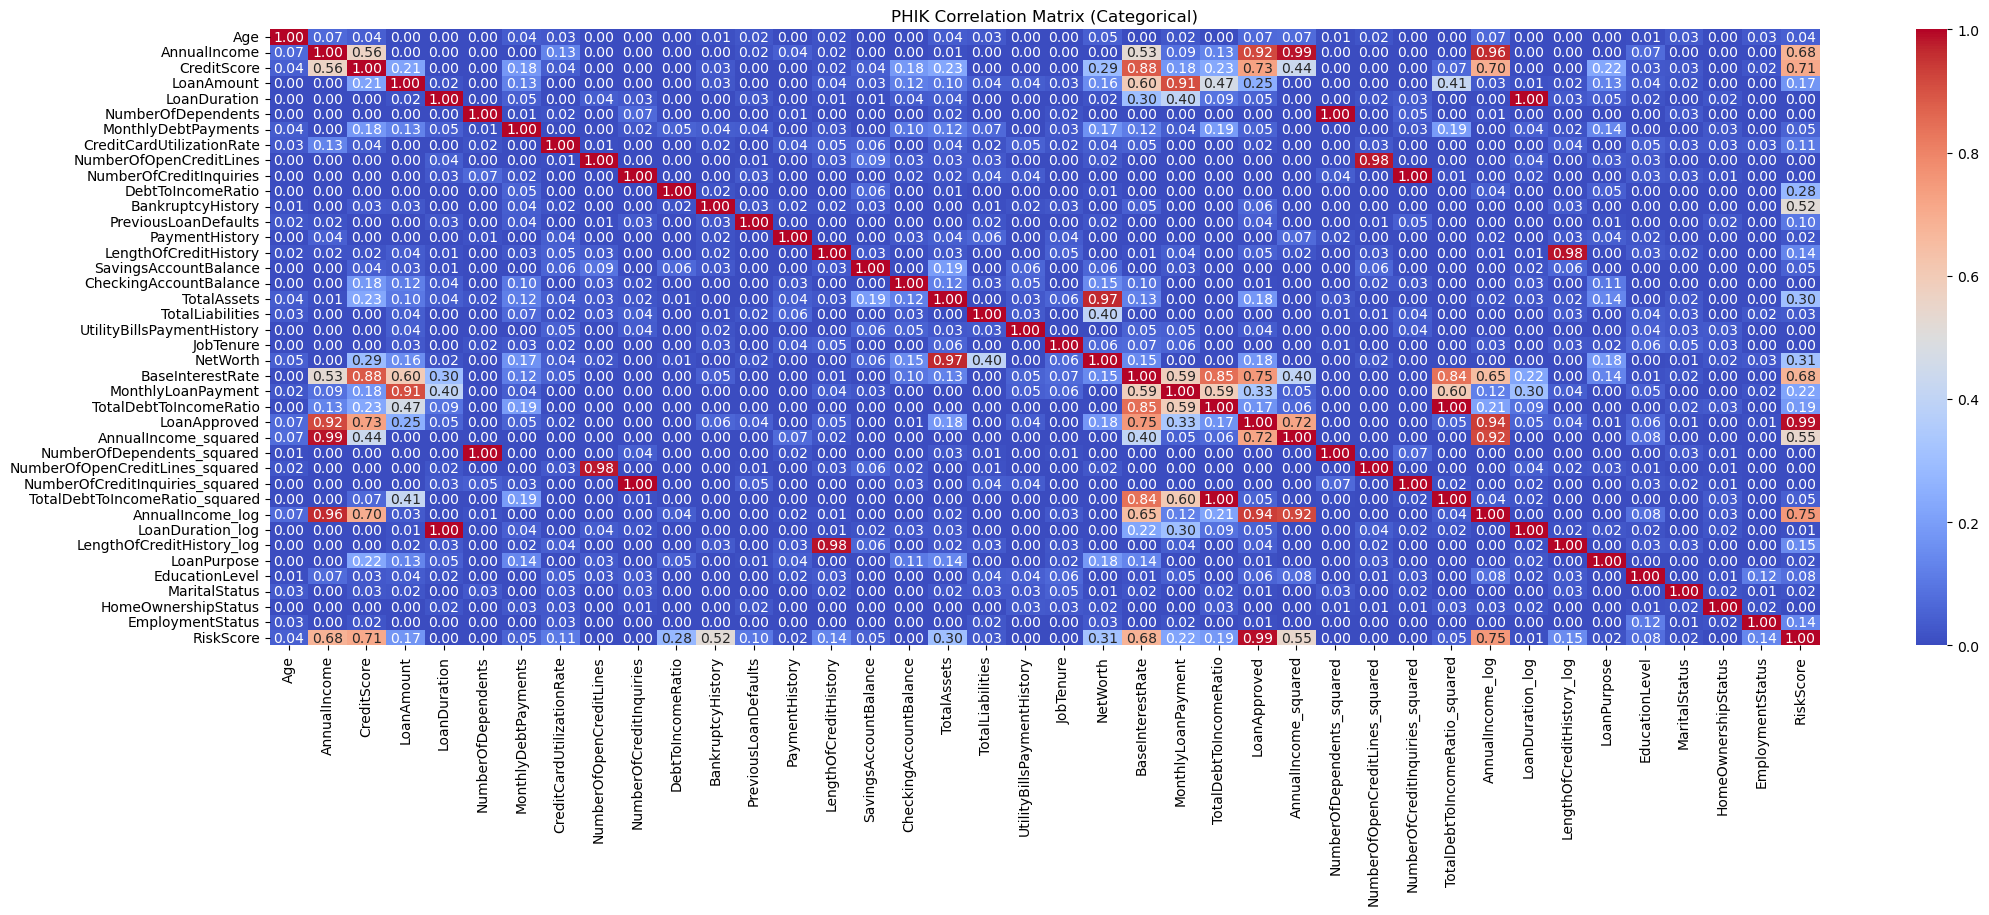

In [1136]:
num_cols = X_train_gen.select_dtypes(include=['number']).columns

phik_matrix = X_train_gen.phik_matrix(interval_cols=list(num_cols))

fig, axes = plt.subplots(figsize=(25, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=axes)
plt.title('PHIK Correlation Matrix (Categorical)')

plt.show()

In [1137]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 
cat_cols = list(X_train_gen.select_dtypes(include=['object']).columns)
scaler = StandardScaler()


In [1138]:
num_cols = list(X_train_gen.select_dtypes(include=['number']).columns)

In [1139]:
num_cols.pop()

'RiskScore'

In [1140]:
ct = ColumnTransformer(
    [
        ('ohe', ohe, cat_cols),
        ('scaler', scaler, num_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [1141]:
X_train = X_train_gen.drop(['RiskScore'], axis = 1)
y_train = X_train_gen['RiskScore']

In [1142]:
X_train.head()

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,NumberOfCreditInquiries_squared,TotalDebtToIncomeRatio_squared,AnnualIncome_log,LoanDuration_log,LengthOfCreditHistory_log,LoanPurpose,EducationLevel,MaritalStatus,HomeOwnershipStatus,EmploymentStatus
0,27.0,66829.0,549.0,9.757941,60.0,1.0,6.999422,0.151985,2.0,1.0,...,1.0,0.082952,11.109907,4.110874,1.791759,Education,Associate,Divorced,Rent,Employed
1,55.0,172147.0,850.0,9.687258,36.0,1.0,5.356586,0.175693,3.0,0.0,...,0.0,0.002559,12.056110,3.610918,2.484907,Home,High School,Widowed,Mortgage,Employed
2,51.0,300000.0,850.0,10.556776,36.0,0.0,6.304449,0.444605,3.0,0.0,...,0.0,0.005267,12.611541,3.610918,2.564949,Education,Bachelor,Married,Mortgage,Employed
3,25.0,34683.0,847.0,9.861988,48.0,0.0,5.036953,0.188452,7.0,0.0,...,0.0,0.050812,10.454034,3.891820,3.091042,Debt Consolidation,High School,Married,Other,Employed
4,55.0,300000.0,850.0,10.323447,48.0,2.0,6.333280,0.273431,3.0,1.0,...,1.0,0.002780,12.611541,3.891820,2.302585,Debt Consolidation,Bachelor,Single,Rent,Employed


In [1143]:
X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test_gen)
X_train_ct

,LoanPurpose_Auto,LoanPurpose_Debt Consolidation,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,EducationLevel_Associate,EducationLevel_Bachelor,EducationLevel_Doctorate,EducationLevel_High School,EducationLevel_Master,...,TotalDebtToIncomeRatio,LoanApproved,AnnualIncome_squared,NumberOfDependents_squared,NumberOfOpenCreditLines_squared,NumberOfCreditInquiries_squared,TotalDebtToIncomeRatio_squared,AnnualIncome_log,LoanDuration_log,LengthOfCreditHistory_log
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.262527,-1.025666,-0.625513,-0.545414,-0.630541,-0.295061,-0.119468,-0.108884,0.455286,-1.160736
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.542063,0.974976,-0.025998,-0.545414,-0.246603,-0.609288,-0.130145,0.704992,-0.549993,-0.182879
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.516178,0.974976,1.411911,-0.702836,-0.246603,-0.609288,-0.129785,1.182746,-0.549993,-0.069959
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.336228,0.974976,-0.703243,-0.702836,2.824907,-0.609288,-0.123737,-0.673033,0.014827,0.672227
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.539548,0.974976,1.411911,-0.073146,-0.246603,-0.295061,-0.130115,1.182746,0.014827,-0.440089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.811333,-1.025666,-0.726537,-0.545414,-0.630541,-0.295061,0.060789,-1.393978,-0.549993,0.308495
9996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.515557,0.974976,0.084069,-0.702836,-0.937692,-0.609288,-0.129775,0.767310,1.122403,0.961141
9997,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.538828,0.974976,1.365403,-0.073146,1.826666,-0.609288,-0.130107,1.173313,1.122403,0.537768
9998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.342562,0.974976,0.281653,-0.702836,0.290912,-0.609288,-0.124055,0.860568,-1.338286,0.034589


## Обучение моделей

In [1144]:
mlflow.set_experiment("Train models")

<Experiment: artifact_location='s3://mlops-check/mlflow/638929146125516419', creation_time=1746626022885, experiment_id='638929146125516419', last_update_time=1746626022885, lifecycle_stage='active', name='Train models', tags={}>

In [1145]:
import copy  

def evaluate_model_cv(
    model,
    model_name: str,
    X,
    y,
    cv_method: Literal['kfold', 'loo'] = 'kfold',
    n_splits: int = 5,
    shuffle: bool = False,
    random_state: Optional[int] = None,
    log_to_mlflow: bool = True,
    return_models: bool = False
) -> dict:

    if cv_method == 'kfold':
        cv = MyKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    elif cv_method == 'loo':
        cv = MyLeaveOneOut()
    else:
        raise ValueError("Invalid cv_method. Choose 'kfold' or 'loo'.")

    mse_scores, r2_scores, mae_scores, mape_scores, fit_times = [], [], [], [], []
    trained_models = []

    X_array = X.values if hasattr(X, 'values') else X
    y_array = y.values if hasattr(y, 'values') else y

    for train_idx, test_idx in cv.split(X_array):
        X_train, X_test = X_array[train_idx], X_array[test_idx]
        y_train, y_test = y_array[train_idx], y_array[test_idx]

        start_time = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_time
        fit_times.append(fit_time)

        y_pred = model.predict(X_test)

        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        try:
            mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))
        except:
            mape_scores.append(np.nan)

        trained_models.append(copy.deepcopy(model))

    results = {
        'model': model_name,
        'mse': np.mean(mse_scores),
        'r2': np.mean(r2_scores),
        'mae': np.mean(mae_scores),
        'mape': np.nanmean(mape_scores),
        'fit_time': np.mean(fit_times),
        'cv_method': cv_method,
        'n_splits': n_splits if cv_method == 'kfold' else len(X_array)
    }

    if log_to_mlflow:
        with mlflow.start_run(run_name=model_name, nested=True):
            if hasattr(model, 'get_params'):
                mlflow.log_params(model.get_params())
            mlflow.log_metrics({
                'mse': results['mse'],
                'r2': results['r2'],
                'mae': results['mae'],
                'mape': results['mape'],
                'avg_fit_time': results['fit_time']
            })
            mlflow.log_params({
                'cv_method': cv_method,
                'n_splits': results['n_splits'],
                'shuffle': shuffle,
                'random_state': random_state
            })

    if return_models:
        return results, trained_models
    else:
        return results


In [1146]:
def evaluate_all_models_cv(X, y, models, cv_method='kfold', n_splits=5, shuffle=True, random_state=42, log_to_mlflow=True):
    results = []
    all_trained_models = {}  

    for name, model, params in models:
        result, trained_models = evaluate_model_cv(
            model=model,
            model_name=name,
            X=X,
            y=y,
            cv_method=cv_method,
            n_splits=n_splits,
            shuffle=shuffle,
            random_state=random_state,
            log_to_mlflow=log_to_mlflow,
            return_models=True  
        )
        results.append(result)
        all_trained_models[name] = trained_models

    df = pd.DataFrame(results)
    print(df.round(4))
    return df, all_trained_models


In [1147]:
X_train

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,NumberOfCreditInquiries_squared,TotalDebtToIncomeRatio_squared,AnnualIncome_log,LoanDuration_log,LengthOfCreditHistory_log,LoanPurpose,EducationLevel,MaritalStatus,HomeOwnershipStatus,EmploymentStatus
0,27.0,66829.0,549.0,9.757941,60.0,1.0,6.999422,0.151985,2.0,1.0,...,1.0,0.082952,11.109907,4.110874,1.791759,Education,Associate,Divorced,Rent,Employed
1,55.0,172147.0,850.0,9.687258,36.0,1.0,5.356586,0.175693,3.0,0.0,...,0.0,0.002559,12.056110,3.610918,2.484907,Home,High School,Widowed,Mortgage,Employed
2,51.0,300000.0,850.0,10.556776,36.0,0.0,6.304449,0.444605,3.0,0.0,...,0.0,0.005267,12.611541,3.610918,2.564949,Education,Bachelor,Married,Mortgage,Employed
3,25.0,34683.0,847.0,9.861988,48.0,0.0,5.036953,0.188452,7.0,0.0,...,0.0,0.050812,10.454034,3.891820,3.091042,Debt Consolidation,High School,Married,Other,Employed
4,55.0,300000.0,850.0,10.323447,48.0,2.0,6.333280,0.273431,3.0,1.0,...,1.0,0.002780,12.611541,3.891820,2.302585,Debt Consolidation,Bachelor,Single,Rent,Employed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,27.0,15000.0,361.0,9.878477,36.0,1.0,6.434547,0.409411,2.0,1.0,...,1.0,1.440274,9.615872,3.610918,2.833213,Education,High School,Single,Other,Employed
9996,49.0,185082.0,573.0,8.915701,84.0,0.0,6.853299,0.095426,0.0,0.0,...,0.0,0.005343,12.128560,4.442651,3.295837,Auto,High School,Married,Mortgage,Employed
9997,55.0,296728.0,850.0,10.695643,84.0,2.0,6.173786,0.373804,6.0,0.0,...,0.0,0.002844,12.600575,4.442651,2.995732,Education,High School,Divorced,Mortgage,Employed
9998,33.0,206277.0,723.0,9.989849,24.0,0.0,5.991465,0.070873,4.0,0.0,...,0.0,0.048415,12.236980,3.218876,2.639057,Home,High School,Married,Mortgage,Self-Employed


In [1156]:
models = [
        ('My Analytic', MyLinearRegression(method='analytic'), {'method': 'analytic'}),
        ('My GD', MyLinearRegression(method='gd', learning_rate=0.01, max_iter=1000),
         {'method': 'gd', 'learning_rate': 0.01, 'max_iter': 1000}),
        ('My SGD', MyLinearRegression(method='sgd', learning_rate=0.01, max_iter=1000),
         {'method': 'sgd', 'learning_rate': 0.01, 'max_iter': 1000}),
        ('Sklearn Linear', LinearRegression(), {}),
        ('My Ridge', MyLinearRegression(method='analytic', regularization='l2', alpha=0.1),
         {'method': 'analytic', 'regularization': 'l2', 'alpha': 0.1}),
        ('Sklearn Ridge', Ridge(alpha=0.1), {'alpha': 0.1}),
        ('My Lasso', MyLinearRegression(method='gd', regularization='l1', alpha=0.1, max_iter=2000),
         {'method': 'gd', 'regularization': 'l1', 'alpha': 0.1, 'max_iter': 2000}),
        ('Sklearn Lasso', Lasso(alpha=0.1), {'alpha': 0.1}),
        ('My ElasticNet', MyLinearRegression(method='gd', regularization='elasticnet', alpha=0.1, l1_ratio=0.5),
         {'method': 'gd', 'regularization': 'elasticnet', 'alpha': 0.1, 'l1_ratio': 0.5}),
        ('Sklearn ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5), {'alpha': 0.1, 'l1_ratio': 0.5}),
        ('My Lp(p=0.5)', MyLinearRegression(method='gd', regularization='lp', alpha=0.1, p=0.5),
         {'method': 'gd', 'regularization': 'lp', 'alpha': 0.1, 'p': 0.5}),
        ('My Lp(p=3)', MyLinearRegression(method='gd', regularization='lp', alpha=0.1, p=3),
         {'method': 'gd', 'regularization': 'lp', 'alpha': 0.1, 'p': 3})
    ]

In [1157]:
res_df, trained_models_dict = evaluate_all_models_cv(X_train_ct, y_train, models, log_to_mlflow=False)


                 model      mse      r2     mae    mape  fit_time cv_method  \
0          My Analytic  17.3290  0.9416  3.2041  0.0708    0.0326     kfold   
1                My GD  21.3700  0.9280  3.5688  0.0796    0.1233     kfold   
2               My SGD  21.5991  0.9272  3.5875  0.0801    0.1125     kfold   
3       Sklearn Linear  17.3459  0.9416  3.2069  0.0709    0.0049     kfold   
4             My Ridge  17.3288  0.9416  3.2040  0.0708    0.0012     kfold   
5        Sklearn Ridge  17.3288  0.9416  3.2040  0.0708    0.0028     kfold   
6             My Lasso  19.2058  0.9353  3.3770  0.0748    0.2443     kfold   
7        Sklearn Lasso  17.6948  0.9404  3.2296  0.0714    0.0141     kfold   
8        My ElasticNet  23.1703  0.9219  3.7102  0.0822    0.1125     kfold   
9   Sklearn ElasticNet  18.2975  0.9384  3.2912  0.0731    0.0147     kfold   
10        My Lp(p=0.5)  21.7700  0.9266  3.6037  0.0805    0.1014     kfold   
11          My Lp(p=3)  38.3581  0.8708  4.8634  0.1

In [1158]:
res_df.sort_values(by = 'mse')

,model,mse,r2,mae,mape,fit_time,cv_method,n_splits
4,My Ridge,17.328825,0.941613,3.204030,0.070788,0.001226,kfold,5
5,Sklearn Ridge,17.328830,0.941613,3.204049,0.070789,0.002769,kfold,5
0,My Analytic,17.328984,0.941613,3.204051,0.070788,0.032559,kfold,5
3,Sklearn Linear,17.345909,0.941556,3.206904,0.070858,0.004882,kfold,5
7,Sklearn Lasso,17.694800,0.940389,3.229559,0.071445,0.014111,kfold,5
9,Sklearn ElasticNet,18.297486,0.938355,3.291183,0.073130,0.014660,kfold,5
6,My Lasso,19.205785,0.935287,3.376971,0.074753,0.244291,kfold,5
1,My GD,21.370035,0.927973,3.568765,0.079608,0.123270,kfold,5
2,My SGD,21.599071,0.927193,3.587537,0.080115,0.112476,kfold,5
10,My Lp(p=0.5),21.770014,0.926627,3.603742,0.080482,0.101443,kfold,5


In [1159]:
best_model = trained_models_dict['My Ridge'][0]
best_model

In [1160]:
X_test_ct

,LoanPurpose_Auto,LoanPurpose_Debt Consolidation,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,EducationLevel_Associate,EducationLevel_Bachelor,EducationLevel_Doctorate,EducationLevel_High School,EducationLevel_Master,...,TotalDebtToIncomeRatio,LoanApproved,AnnualIncome_squared,NumberOfDependents_squared,NumberOfOpenCreditLines_squared,NumberOfCreditInquiries_squared,TotalDebtToIncomeRatio_squared,AnnualIncome_log,LoanDuration_log,LengthOfCreditHistory_log
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.553760,0.974976,0.289707,-0.702836,-0.630541,-0.609288,-0.130265,0.863972,0.455286,0.222969
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.066621,-1.025666,-0.632328,-0.073146,0.290912,0.647619,-0.103062,-0.137357,0.014827,1.061951
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.560507,0.974976,1.411911,-0.545414,0.982001,-0.609288,-0.130323,1.182746,0.455286,-0.440089
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.500888,0.974976,1.411911,-0.702836,-0.630541,-0.295061,-0.129512,1.182746,-0.549993,-0.440089
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.526614,0.974976,1.411911,4.964372,-0.937692,-0.609288,-0.129946,1.182746,0.455286,-0.943268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.568640,0.974976,1.411911,-0.545414,0.982001,-0.295061,-0.130380,1.182746,0.455286,-0.069959
4996,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.247198,-1.025666,-0.597859,-0.702836,-0.630541,-0.295061,-0.118450,-0.009505,0.014827,0.606599
4997,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.566999,-1.025666,-0.726537,-0.545414,-0.630541,-0.609288,0.000357,-1.393978,0.816386,0.852568
4998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.494587,-1.025666,-0.500943,-0.545414,-0.860904,-0.295061,-0.129387,0.224493,1.387940,0.034589


In [1161]:
y_pred = best_model.predict(X_test_ct)
y_pred

array([33.02735227, 54.65228242, 31.07664829, ..., 62.56489593,
       50.00242081, 74.90595207])

In [1162]:
pred_df = pd.DataFrame(y_pred)
pred_df.columns = ['RiskScore']

In [1163]:
pred_df.to_csv("predictions.csv", index=True, index_label='ID')
